In [ ]:
%pip install numpy cython scipy pandas scikit-learn statsmodels joblib
%pip install pmdarima

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from itertools import product
from typing import Union
import itertools
import ast
import re
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

df = pd.read_excel('./italy_values_dataset.xlsx')

In [28]:
# plot styles
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

In [3]:
CATEGORIES = {
    'demography': ['population', 'growth', 'employment', 'Employment'],
    'land_use': ['area', 'land', 'cropland'],
    'prerequisites': ['withdrawals', 'fertilizer'],
    'production': ['production', 'yield'],
    'economy': ['value', 'added', 'value added', 'exports', 'imports']        
}

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

In [ ]:
# def prepare_wide_dataset(df, target):
#     if 'Indicator Name' not in df.columns:
#         raise ValueError("Il DataFrame deve contenere una colonna 'Indicator Name'")
#     year_cols = [col for col in df.columns if str(col).isdigit()]
#     df_long = df.melt(id_vars='Indicator Name', value_vars=year_cols,
#                     var_name='Year', value_name='Value')
    
#     df_wide = df_long.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()
#     df_wide['Year'] = df_wide['Year'].astype(int)
#     df_wide = df_wide.sort_values('Year').reset_index(drop=True)
#     df_wide.columns.name = None
    
#     def remove_unusable_variables(target, indicators, df_wide):
#         unusable_cols = [col for col in df_wide.columns if col in UNUSABLE]
#         if unusable_cols:
#             df_wide = df_wide.drop(columns=unusable_cols).copy()
#         else:
#             print("Nessuna colonna inutilizzabile presente in df_wide")
#         if 'Year' not in df_wide.columns:
#             raise ValueError("df_wide deve contenere la colonna 'Year'")
#         indicators = [ind for ind in dict.fromkeys(indicators) if ind in df_wide.columns or ind == target]
#         return df_wide

#     indicators = [i for i in df["Indicator Name"].unique() if i not in UNUSABLE]
#     df_wide = remove_unusable_variables(target, indicators, df_wide)
#     return df_wide

In [4]:
def prepare_wide_dataset(df, target):
    if 'Indicator Name' not in df.columns:
        raise ValueError("Il DataFrame deve contenere una colonna 'Indicator Name'")
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df_long = df.melt(id_vars='Indicator Name', value_vars=year_cols,
                    var_name='Year', value_name='Value')
    
    df_wide = df_long.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()
    df_wide['Year'] = df_wide['Year'].astype(int)
    df_wide = df_wide.sort_values('Year').reset_index(drop=True)
    df_wide.columns.name = None
    
    # Verifica che la target sia presente
    if target not in df_wide.columns:
        raise ValueError(f"La variabile target '{target}' non è presente nel dataset wide")
    
    # Rimuovi variabili inutilizzabili (tranne la target)
    unusable_cols = [col for col in df_wide.columns if col in UNUSABLE and col != target]
    if unusable_cols:
        df_wide = df_wide.drop(columns=unusable_cols)
    
    return df_wide

In [5]:
def calculate_d_parameter(series):
    def is_stationary(series):
        result = adfuller(series.dropna())
        return result[1] < 0.05  # p-value < 0.05 → stazionaria
    
    if is_stationary(series) : 
        #print("Serie stazionaria")
        return 0
    else:
        current_series = series.copy()
        for d in range(1, 3):
            current_series = current_series.diff()
            result = adfuller(current_series.dropna())
            if result[1] < 0.05:
                #print(f"Serie non stazionaria -> differenziazione d={d}")
                return d
            else:
                d += 1
    #print("Uso differenziazione d=1 come fallback")
    return 1

In [6]:
def categorize_var(col):
    col_clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', col.lower())  # rimuove simboli come % ( ) ecc.
    for category, keywords in CATEGORIES.items():
        for keyword in keywords:
            if keyword in col_clean:
                return category
    return 'other'

In [7]:
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.feature_selection import mutual_info_regression

def calculate_relevance_score(target, candidate, wide_df):
    """
    Calcola rilevanza usando test statistici robusti
    Restituisce punteggio 0-1 basato su evidenza statistica
    """
    try:
        data = wide_df[[target, candidate]].dropna()
        if len(data) < 15:
            return 0
        
        scores = []
        
        # 1. CORRELAZIONE (25%)
        correlation = abs(data.corr().iloc[0, 1])
        if not np.isnan(correlation):
            scores.append(('correlation', correlation * 0.25))

        # 2. GRANGER CAUSALITY (35%) = verifica se X aiuta a prevedere Y
        def granger_causality_test(target, candidate, wide_df, maxlag=2):
            try:
                data = wide_df[[target, candidate]].dropna()
                if len(data) < 20:
                    return 0

                test_result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
                # Prendi il p-value minimo tra tutti i lag
                min_pvalue = min([test_result[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag+1)])
                
                # P-value basso = causalità Granger significativa
                if min_pvalue < 0.05:
                    return 1.0  # Relazione forte
                elif min_pvalue < 0.1:
                    return 0.7  # Relazione moderata
                else:
                    return 0.3  # Relazione debole
            except:
                return 0

        granger_score = granger_causality_test(target, candidate, wide_df)
        scores.append(('granger', granger_score * 0.35))
        
        # 3. MUTUAL INFORMATION (25%) = misura dipendenze non-lineari
        def mutual_information_score(target, candidate, wide_df):
            try:
                data = wide_df[[target, candidate]].dropna()
                if len(data) < 15:
                    return 0
                
                X = data[candidate].values.reshape(-1, 1)
                y = data[target].values
                mi = mutual_info_regression(X, y, random_state=42)[0]
                
                # Normalizza tra 0 e 1
                return min(mi * 10, 1.0)
            except:
                return 0
        
        mi_score = mutual_information_score(target, candidate, wide_df)
        scores.append(('mutual_info', mi_score * 0.25))
        
        # 4. STABILITY - numero di osservazioni (15%)
        stability_score = min(len(data) / 50, 1.0)  # Normalizza su 50 osservazioni
        scores.append(('stability', stability_score * 0.15))
        
        # Punteggio totale
        total_score = sum(score for _, score in scores)
        return min(total_score, 1.0)
        
    except Exception as e:
        print(f"Errore nel calcolo rilevanza {target}-{candidate}: {e}")
        return 0

In [8]:
def select_one_per_category(target, candidates):
    # trovo categoria del target
    target_category = categorize_var(target)
    selected_exog = []
    used_categories = set()

    if target_category:
        used_categories.add(target_category)  # tolgo variabili della stessa categoria del target
    
    # 1: seleziono una exog per categoria diversa
    for c in candidates:
        if c['category'] in used_categories: continue
        else: 
            selected_exog.append(c)
            used_categories.add(c['category'])
    return selected_exog
        

In [17]:
def select_exogenous(wide_df, target):
    candidates_exog = []
    for col in wide_df.columns:
        if col == target: continue
        if col == 'Year': continue
        candidates_exog.append({
            'name': col,
            'category': categorize_var(col) or 'other',
            'relevance_score': calculate_relevance_score(target, col, wide_df),
            'data_points': wide_df[col].notna().sum()
        })
    
    # ordino per rilevanza così mi prende la prima esogena per rilevanza di ogni categoria
    candidates_exog.sort(key=lambda x: x['relevance_score'], reverse=True)
    # print('prime 5 per rilevanze')
    # for c in candidates_exog[:5]:
    #     print(f"{c['name']}: {c['category']}")
    # print('\n')
    
    selected = select_one_per_category(target, candidates_exog)
    return selected

In [36]:
def optimize_SARIMAX(target, exog, d):   
    best_aic = float('inf')
    best_order = None
    results = []
    
    for p, q in itertools.product(range(0, 7), 
                                range(0, 7)):
        if p == 0 and q == 0: continue
            
        try:
            model = SARIMAX(target,
                        exog=exog,
                        order=(p, d, q),
                        seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            fitted_model = model.fit(disp=False, maxiter=200)
            
            results.append({
                'order': (p, d, q),
                'aic': fitted_model.aic,
                'converged': True
            })
            
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_order = (p, d, q)
                
        except Exception as e:
            results.append({
                'order': (p, d, q),
                'aic': np.nan,
                'converged': False,
                'error': str(e)
            })
            continue
    
    # Ordina risultati per AIC
    valid_results = [r for r in results if r['converged']]
    valid_results.sort(key=lambda x: x['aic'])
    
    return {
            'target': target,
            'best_order': best_order,
            'best_aic': best_aic,
            'valid_results': valid_results
        }

In [19]:
# DEBUG: verifica che tutto sia allineato
def debug_alignment(target, exog):
    print(f"{'/'*30} VERIFICA ALLINEAMENTO: {'/'*30}")
    print(f"   Target series length: {len(target)}")
    print(f"   Exog data shape: {exog.shape}")
    print(f"   Target index: {target.index[:5].tolist()}")
    print(f"   Exog index: {exog.index[:5].tolist()}")
    
    # Verifica che gli indici siano identici
    indices_match = target.index.equals(exog.index)
    print(f"Indici allineati: {indices_match}")

In [37]:
indicators = [i for i in df["Indicator Name"].unique() if i not in UNUSABLE]
df_orders = pd.DataFrame(columns=["Target", "Best order", "Best AIC", "N_Exog", "Exog_Used"])

for target in indicators:
    wide_df = prepare_wide_dataset(df, target)
    d = calculate_d_parameter(wide_df[target])
    selected_exog = select_exogenous(wide_df, target)
    if selected_exog and isinstance(selected_exog, list):
        if isinstance(selected_exog[0], dict): exog_names = [exog['name'] for exog in selected_exog]
        else: exog_names = selected_exog
    else: exog_names = []
    
    if exog_names: data_subset = wide_df[['Year', target] + exog_names].dropna()
    else: 
        print("Nessuna esogena valida")
        continue
    
    if len(data_subset) < 20:
        print("Troppi pochi dati dopo allineamento")
        continue
    
    # resoconto
    print(f"{'-'*30} TARGET: {target.upper()} {'-'*30}")
    print(f"Numero di differenziazioni necessarie a rendere stazionaria la serie: {d}")
    print("Esogene selezionate:")
    for i, e in enumerate(selected_exog, 1):
        if isinstance(e, dict):
            name = e.get('name', '')
            cat = e.get('category', 'other')
            score = e.get('relevance_score', np.nan)
            print(f"  {i:2d}. {name} — {cat} — rilevanza: {score:.3f}")
        else:
            print(f"  {i:2d}. {e}")
    print(f"Periodo: {data_subset['Year'].min()}-{data_subset['Year'].max()}")
    print(f"Osservazioni: {len(data_subset)}")
    optimized = (optimize_SARIMAX(data_subset[target], data_subset[exog_names], d))
    if optimized:
        best_order = optimized.get('best_order')
        best_aic = optimized.get('best_aic', np.nan)
    else:
        best_order = None
        best_aic = np.nan

    new_row = pd.DataFrame({
        'Target': [target],
        'Best order': [best_order],
        'Best AIC': [best_aic],
        'N_Exog': [len(exog_names)],
        'Exog_Used': [exog_names]
    })
    df_orders = pd.concat([df_orders, new_row], ignore_index=True)
    print(f"Salvato: Target = {target},")
    print(f"--> Best order = {best_order},")
    print(f"--> Best AIC = {best_aic},")
    print(f"--> N_Exog = {len(exog_names)},")
    print(f"--> Exog used = {exog_names}")
    # debug_alignment(data_subset[target], data_subset[exog_names])
print(df_orders)

------------------------------ TARGET: RURAL POPULATION (% OF TOTAL POPULATION) ------------------------------
Numero di differenziazioni necessarie a rendere stazionaria la serie: 1
Esogene selezionate:
   1. Arable land (hectares per person) — land_use — rilevanza: 0.989
   2. Agricultural raw materials imports (% of merchandise imports) — economy — rilevanza: 0.984
   3. Cereal yield (kg per hectare) — production — rilevanza: 0.970
   4. Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal) — prerequisites — rilevanza: 0.855
Periodo: 1970-2021
Osservazioni: 52
Salvato: Target = Rural population (% of total population),
--> Best order = (2, 1, 0),
--> Best AIC = -143.9613492863607,
--> N_Exog = 4,
--> Exog used = ['Arable land (hectares per person)', 'Agricultural raw materials imports (% of merchandise imports)', 'Cereal yield (kg per hectare)', 'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)']
------------------------------ TAR

In [13]:
def recursive_forecast(endog, exog, train_len, horizon, window, method, p, d, q) -> list:
    total_len = len(endog)
    
    if method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            if i == 0: last_value = 0
            else: last_value = endog[:i].iloc[-1]
            steps = min(window, total_len - i)
            pred_last_value.extend([last_value] * steps)
        return pred_last_value[:horizon]
    
    elif method == 'ARIMAX':
        pred_ARIMAX = []
        for i in range(train_len, total_len, window):
            try:
                # Addestra sul dati fino a i
                model = SARIMAX(endog[:i], exog=exog[:i] if exog is not None else None, 
                            order=(p, d, q), seasonal_order=(0, 0, 0, 0), 
                            simple_differencing=False)
                res = model.fit(disp=False)
                
                # Forecast per i prossimi 'window' passi
                steps = min(window, total_len - i)
                
                if exog is not None:
                    # Usa le esogene FUTURE per il forecast
                    exog_forecast = exog.iloc[i:i+steps]
                    forecast = res.get_forecast(steps=steps, exog=exog_forecast)
                else:
                    forecast = res.get_forecast(steps=steps)
                
                pred_ARIMAX.extend(forecast.predicted_mean.values)
                
            except Exception as e:
                # Fallback: usa l'ultimo valore osservato
                print(f"ARIMAX failed at step {i}: {e}")
                last_value = endog[:i].iloc[-1] if i > 0 else 0
                steps = min(window, total_len - i)
                pred_ARIMAX.extend([last_value] * steps)
        
        return pred_ARIMAX[:horizon]  # ← Restituisci solo l'orizzonte richiesto

In [38]:
all_results = {}
for target in indicators:
    try:
        print(f"{'-'*30} {target.upper()} {'-'*30}")
        wide_df = prepare_wide_dataset(df, target)
        
        # prendo riga con cose che ho calcolato di quel target
        row = df_orders[df_orders["Target"] == target]
        if row.empty:
            print(f"Target '{target}' not found in df_orders")
            continue
        
        # riprendo p d q
        best_order_val = row['Best order'].iloc[0]
        if isinstance(best_order_val, str):
            order = ast.literal_eval(best_order_val)
        else:
            order = tuple(best_order_val)
        p, d, q = map(int, order)
        
        # riprendo esogene ottimizzate
        exog_val = row['Exog_Used'].iloc[0]
        if not isinstance(exog_val, list):
            exog_val = [exog_val] if exog_val else []

        # filtro solo colonne che mi servono: anno, time serie target e time serie esogene
        keep_cols = ['Year', target] + [c for c in exog_val if c in wide_df.columns]
        keep_cols = list(dict.fromkeys(keep_cols))  # rimuovo duplicati mantenendo ordine

        # creo subset droppando i nan, se troppi pochi dati skippa
        data_subset = wide_df[keep_cols].dropna().reset_index(drop=True)
        if len(data_subset) < 20:
            print(f"Dati insufficienti dopo il dropna() ({len(data_subset)} righe)")
            continue
        
        # divido in train e test set
        TRAIN_LEN = int(0.8 * len(data_subset))
        TOTAL_LEN = len(data_subset)
        HORIZON = TOTAL_LEN - TRAIN_LEN
        WINDOW = 1
        
        # endogena = target, esogene = quelle calcolate prima
        endog = data_subset[target]
        exog = data_subset[exog_val] if exog_val else None

        pred_ARIMAX = recursive_forecast(
            endog, exog, 
            train_len=TRAIN_LEN, 
            horizon=HORIZON, 
            window=WINDOW, 
            method='ARIMAX', 
            p=p, d=d, q=q
        )

        pred_last_value = recursive_forecast(
            endog, None,
            train_len=TRAIN_LEN, 
            horizon=HORIZON, 
            window=WINDOW, 
            method='last', 
            p=p, d=d, q=q
        )

        results_df = data_subset.iloc[TRAIN_LEN:].copy()
        results_df = results_df.rename(columns={target: 'actual'})
        results_df['pred_ARIMAX'] = pred_ARIMAX
        results_df['pred_last_value'] = pred_last_value
        
        # salvo df risultati in dizionario con tutti
        all_results[target] = results_df
        print(results_df[['Year', 'actual', 'pred_ARIMAX', 'pred_last_value']].head())

    except Exception as e:
        print(f"Errore processing {target}: {e}")
        continue

------------------------------ RURAL POPULATION (% OF TOTAL POPULATION) ------------------------------
    Year  actual  pred_ARIMAX  pred_last_value
41  2011  31.556    31.501447           31.673
42  2012  31.316    31.581684           31.556
43  2013  31.021    31.053627           31.316
44  2014  30.728    30.759928           31.021
45  2015  30.435    30.460294           30.728
------------------------------ RURAL POPULATION GROWTH (ANNUAL %) ------------------------------
    Year    actual  pred_ARIMAX  pred_last_value
26  2016 -1.147508    -1.202247        -1.109249
27  2017 -1.151428    -1.080882        -1.147508
28  2018 -0.745903    -1.170256        -1.151428
29  2019 -1.713177    -0.654919        -0.745903
30  2020 -1.527891    -1.618706        -1.713177
------------------------------ RURAL POPULATION ------------------------------
    Year      actual   pred_ARIMAX  pred_last_value
48  2010  18946601.0  1.899403e+07       18933274.0
49  2011  18942070.0  1.894282e+07       

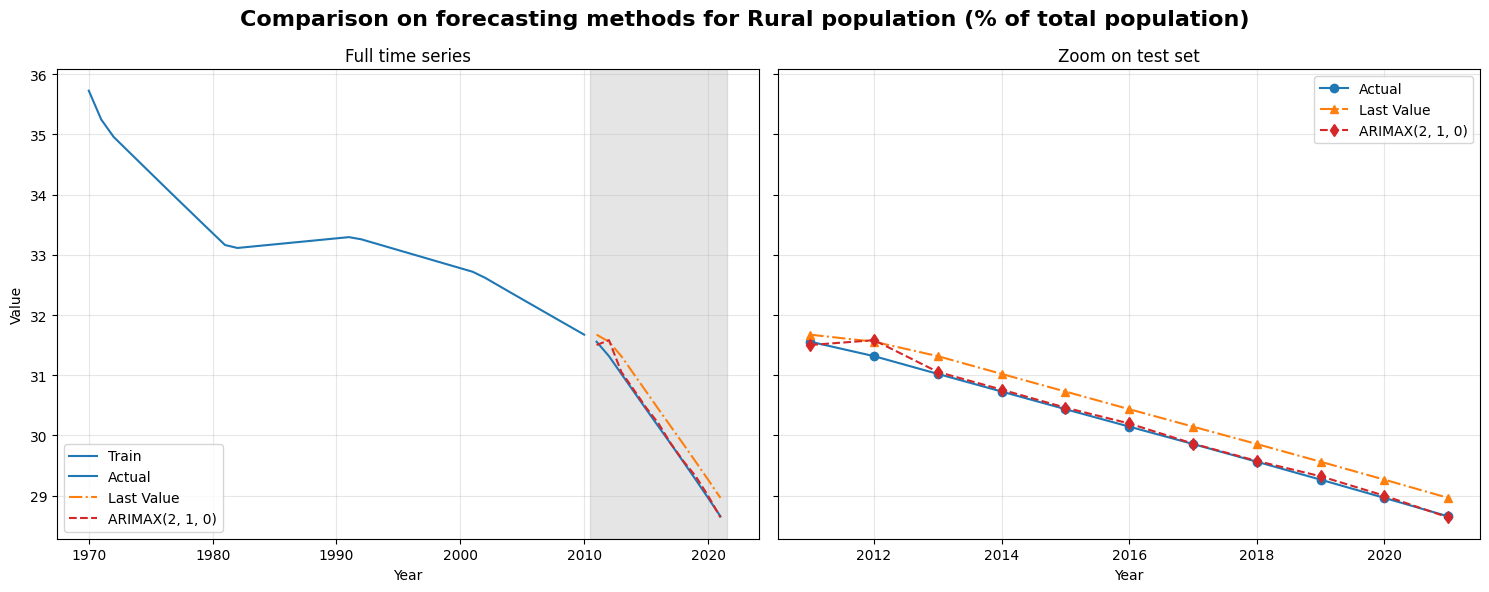

Metriche di errore per Rural population (% of total population):
  MAE -> Last Value: 0.27445, ARIMAX(2, 1, 0): 0.05380
  MSE -> Last Value: 0.07808, ARIMAX(2, 1, 0): 0.00764


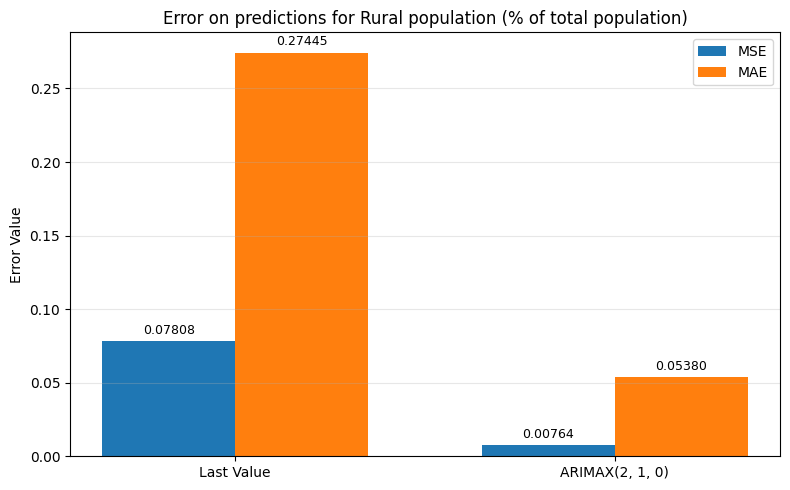

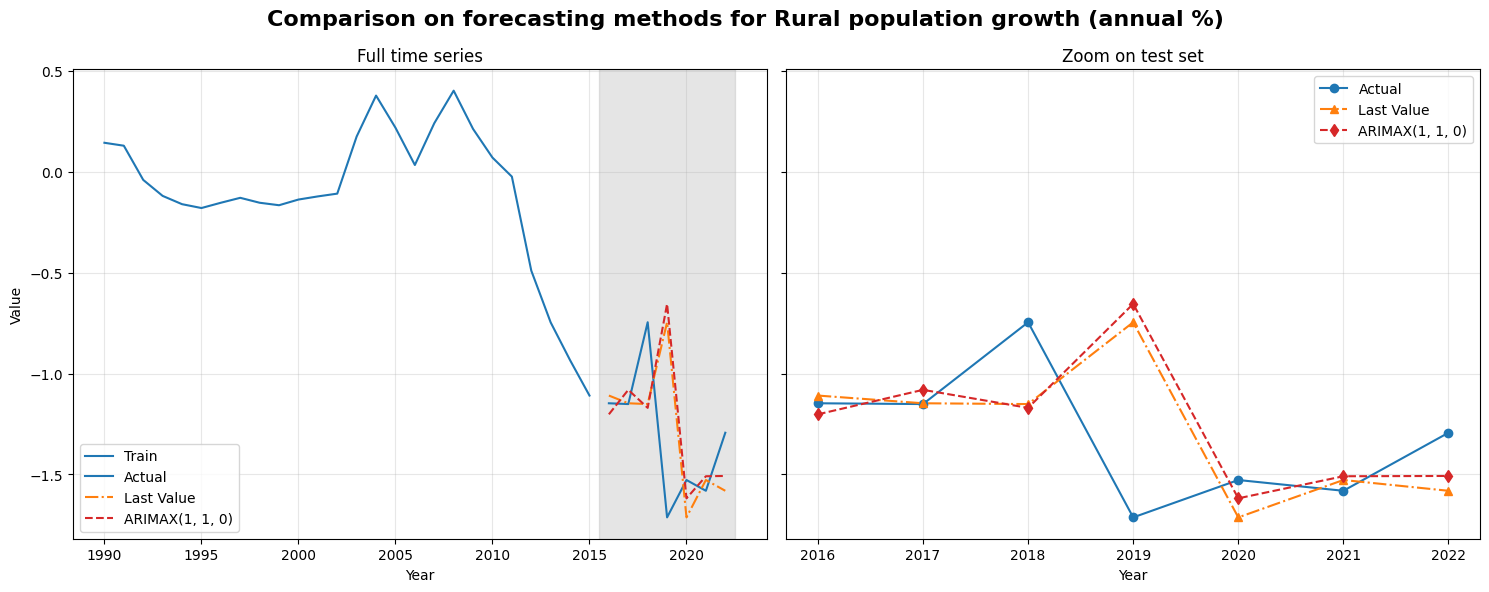

Metriche di errore per Rural population growth (annual %):
  MAE -> Last Value: 0.27734, ARIMAX(1, 1, 0): 0.28357
  MSE -> Last Value: 0.17450, ARIMAX(1, 1, 0): 0.19533


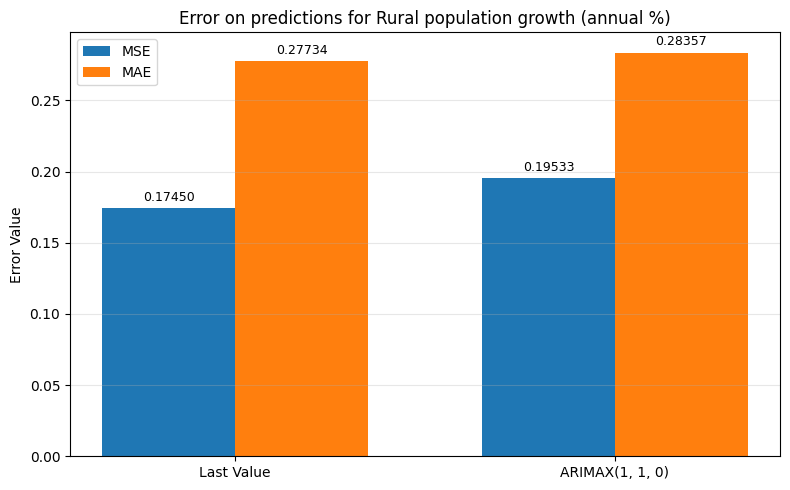

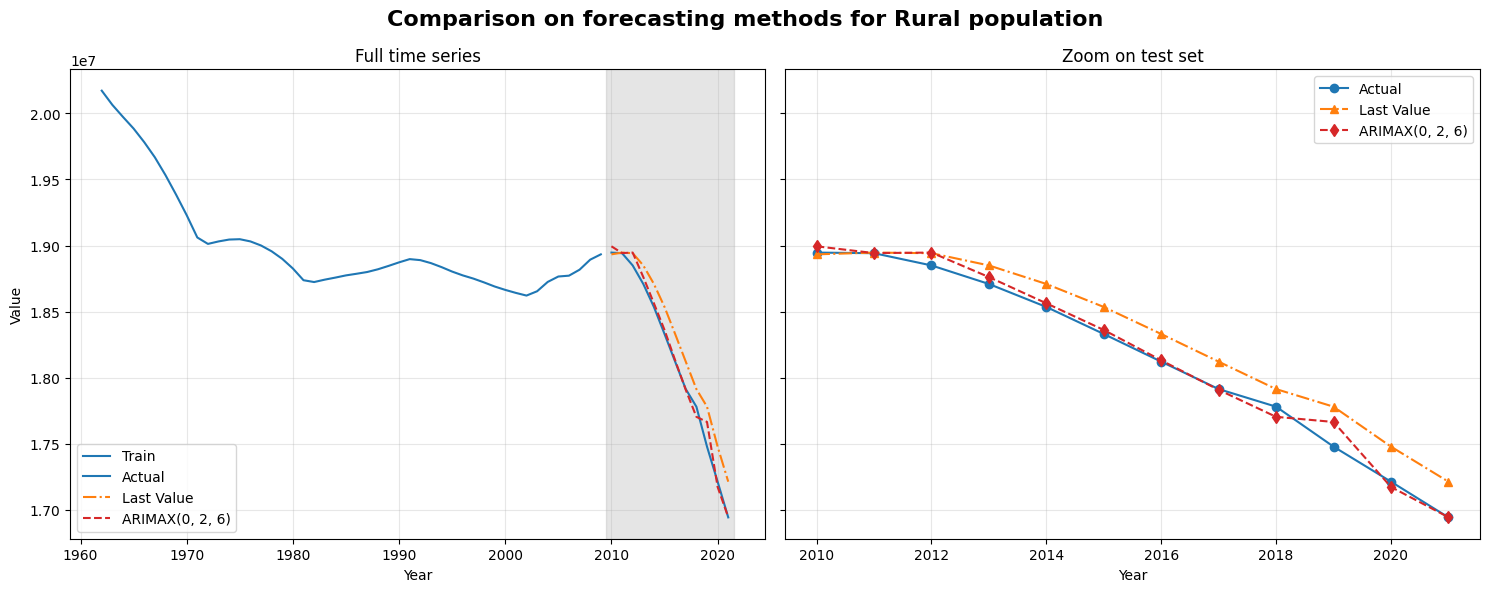

Metriche di errore per Rural population:
  MAE -> Last Value: 167992.41667, ARIMAX(0, 2, 6): 48049.69304
  MSE -> Last Value: 36615890579.41666, ARIMAX(0, 2, 6): 4880036433.21917


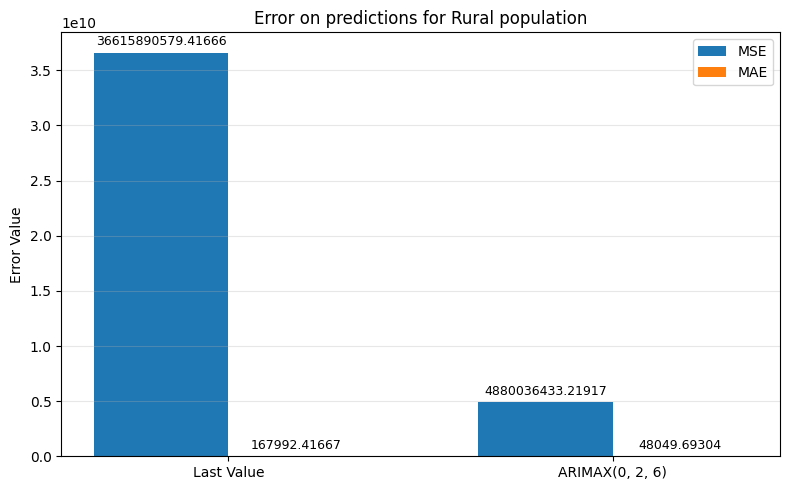

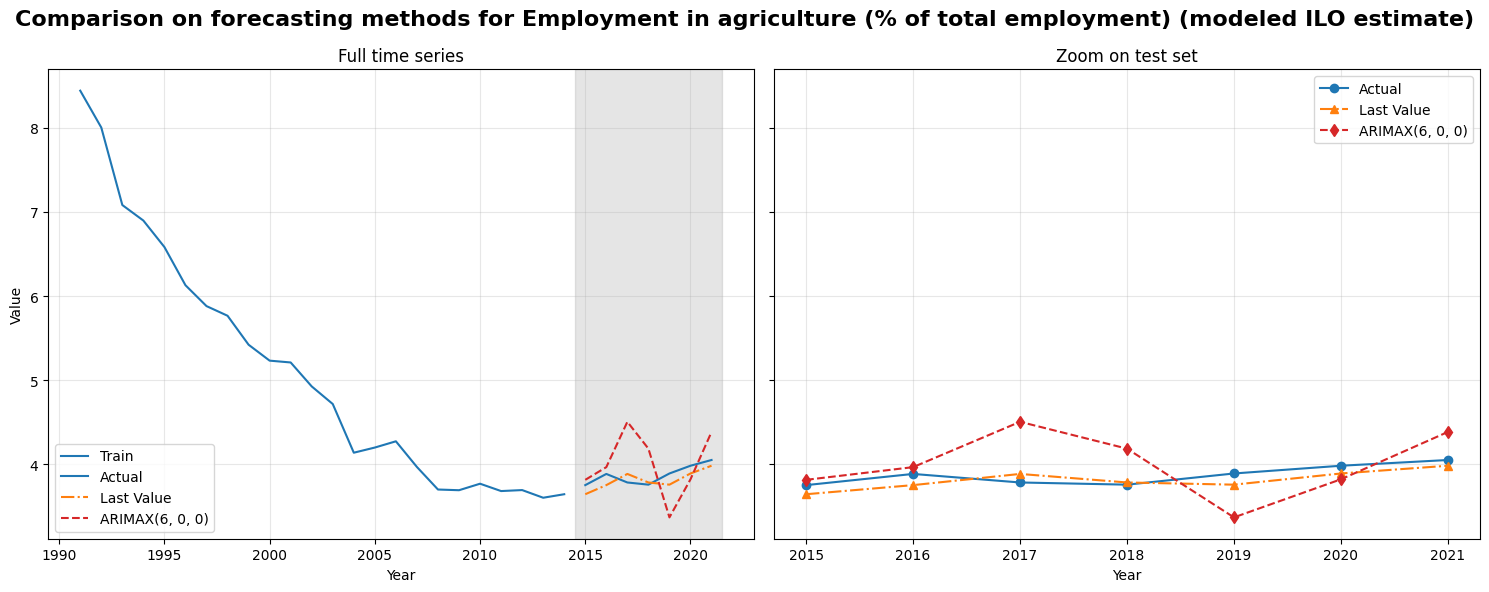

Metriche di errore per Employment in agriculture (% of total employment) (modeled ILO estimate):
  MAE -> Last Value: 0.09461, ARIMAX(6, 0, 0): 0.33010
  MSE -> Last Value: 0.01018, ARIMAX(6, 0, 0): 0.16065


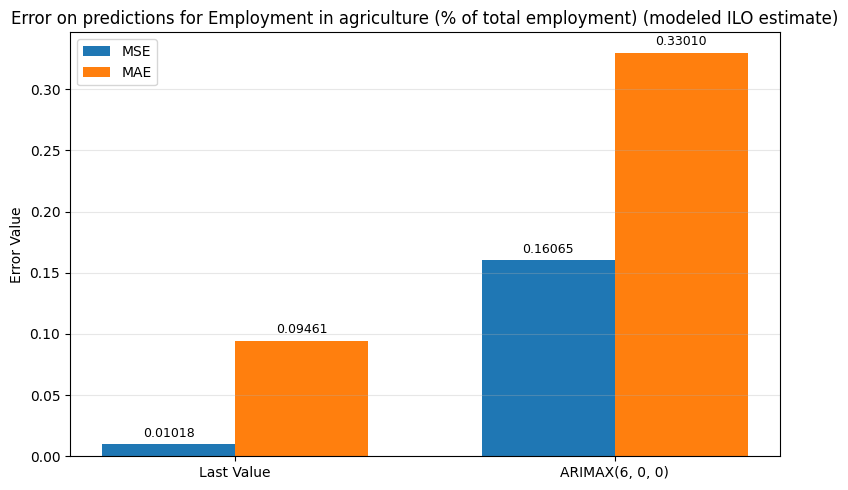

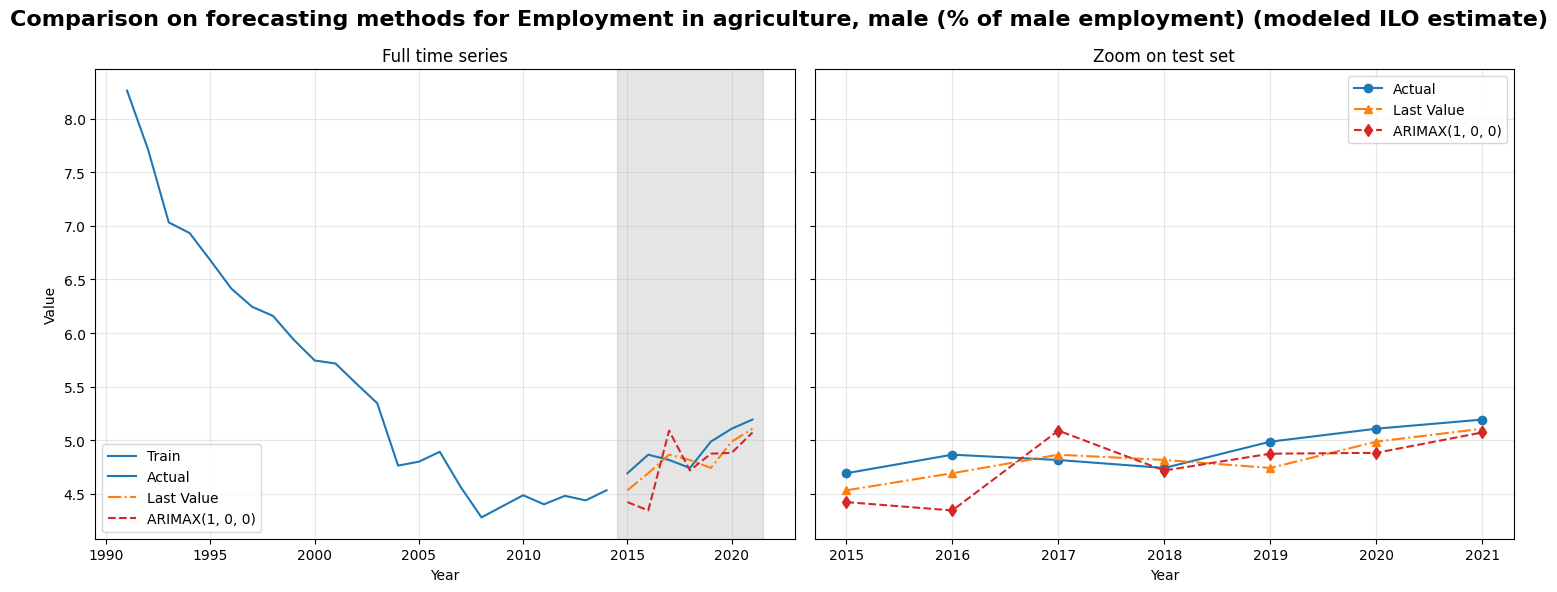

Metriche di errore per Employment in agriculture, male (% of male employment) (modeled ILO estimate):
  MAE -> Last Value: 0.12980, ARIMAX(1, 0, 0): 0.22087
  MSE -> Last Value: 0.02080, ARIMAX(1, 0, 0): 0.07105


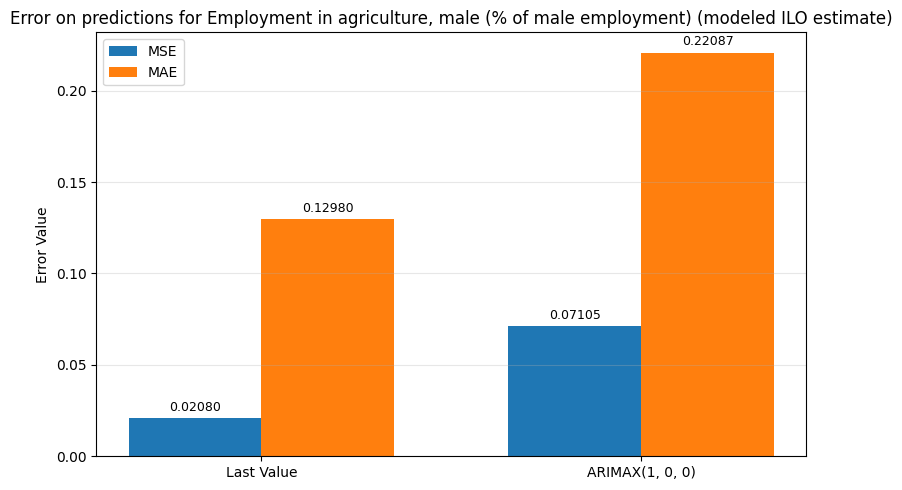

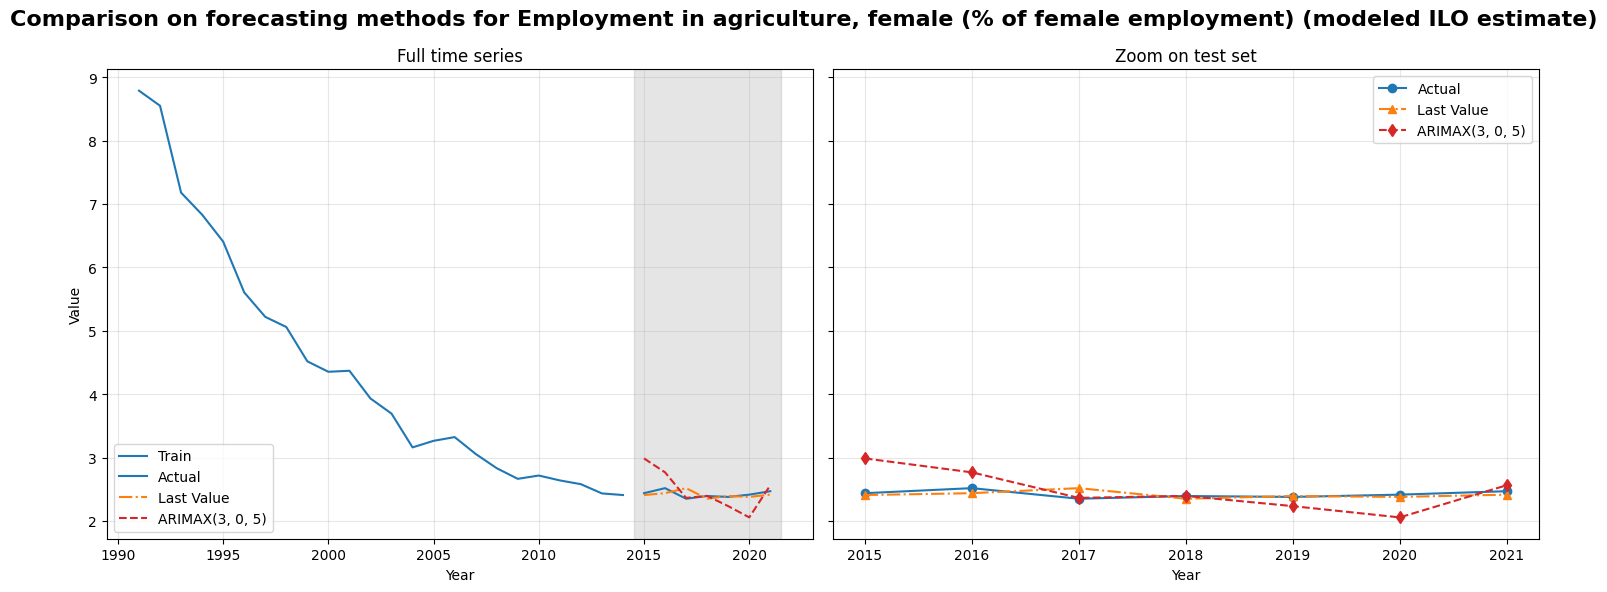

Metriche di errore per Employment in agriculture, female (% of female employment) (modeled ILO estimate):
  MAE -> Last Value: 0.06040, ARIMAX(3, 0, 5): 0.20149
  MSE -> Last Value: 0.00590, ARIMAX(3, 0, 5): 0.07451


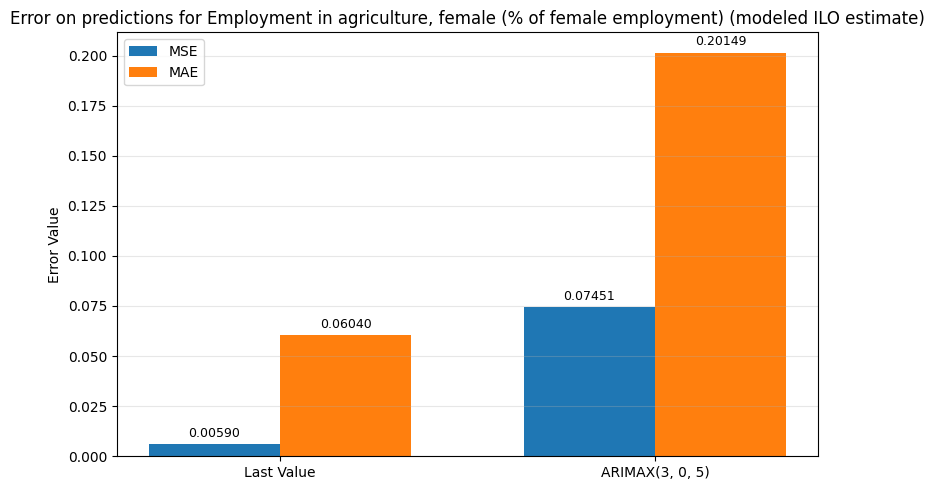

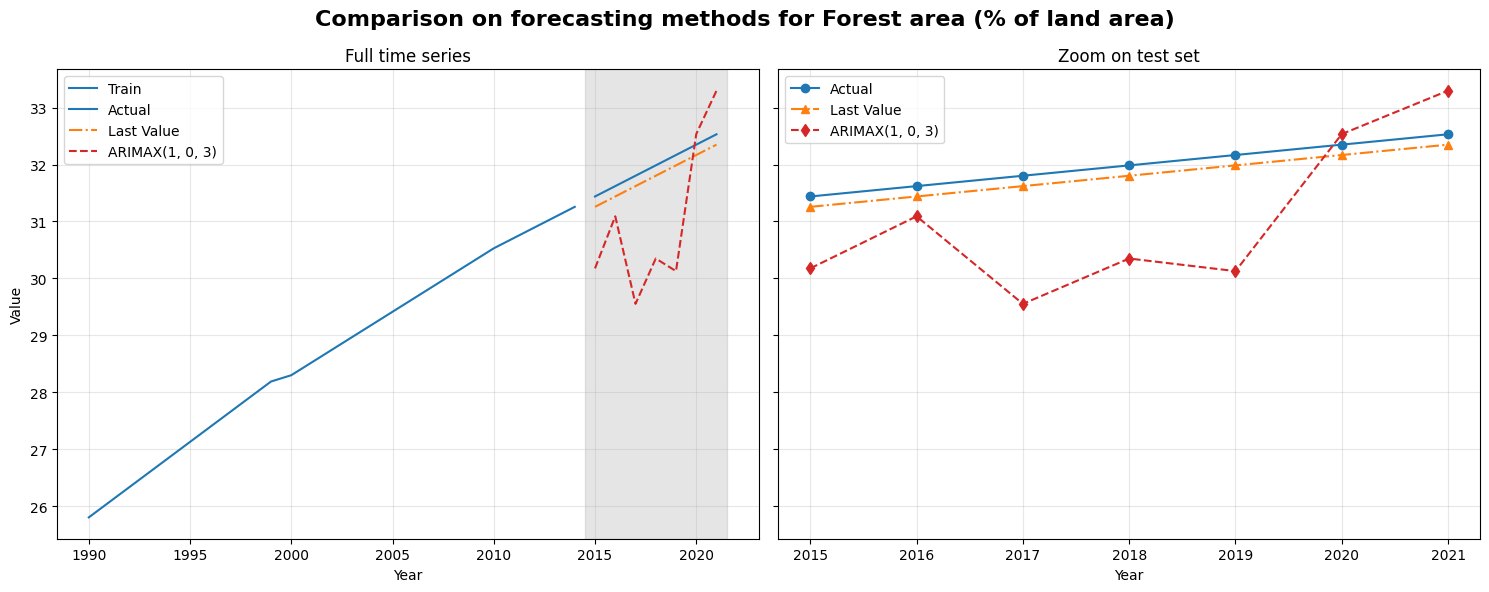

Metriche di errore per Forest area (% of land area):
  MAE -> Last Value: 0.18198, ARIMAX(1, 0, 3): 1.23787
  MSE -> Last Value: 0.03312, ARIMAX(1, 0, 3): 2.05395


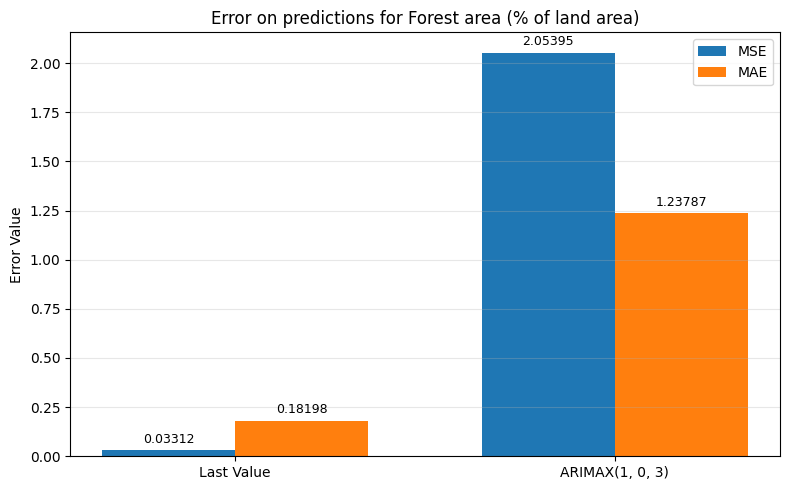

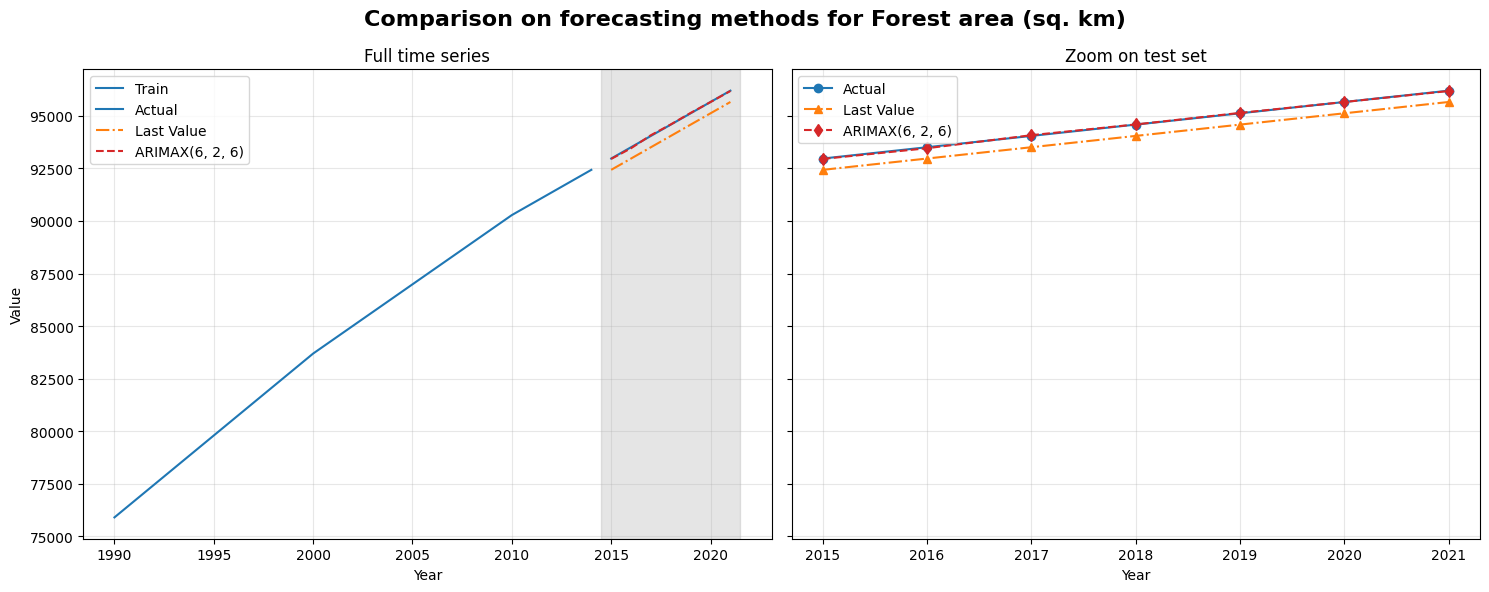

Metriche di errore per Forest area (sq. km):
  MAE -> Last Value: 538.09714, ARIMAX(6, 2, 6): 20.63978
  MSE -> Last Value: 289548.53520, ARIMAX(6, 2, 6): 636.82031


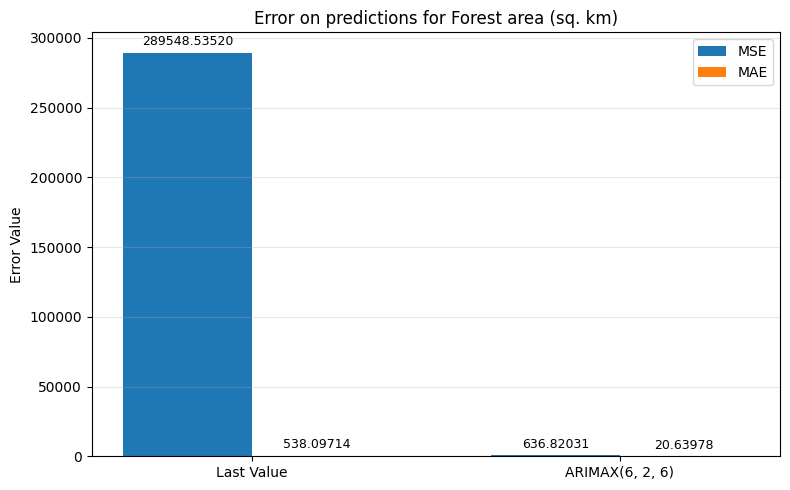

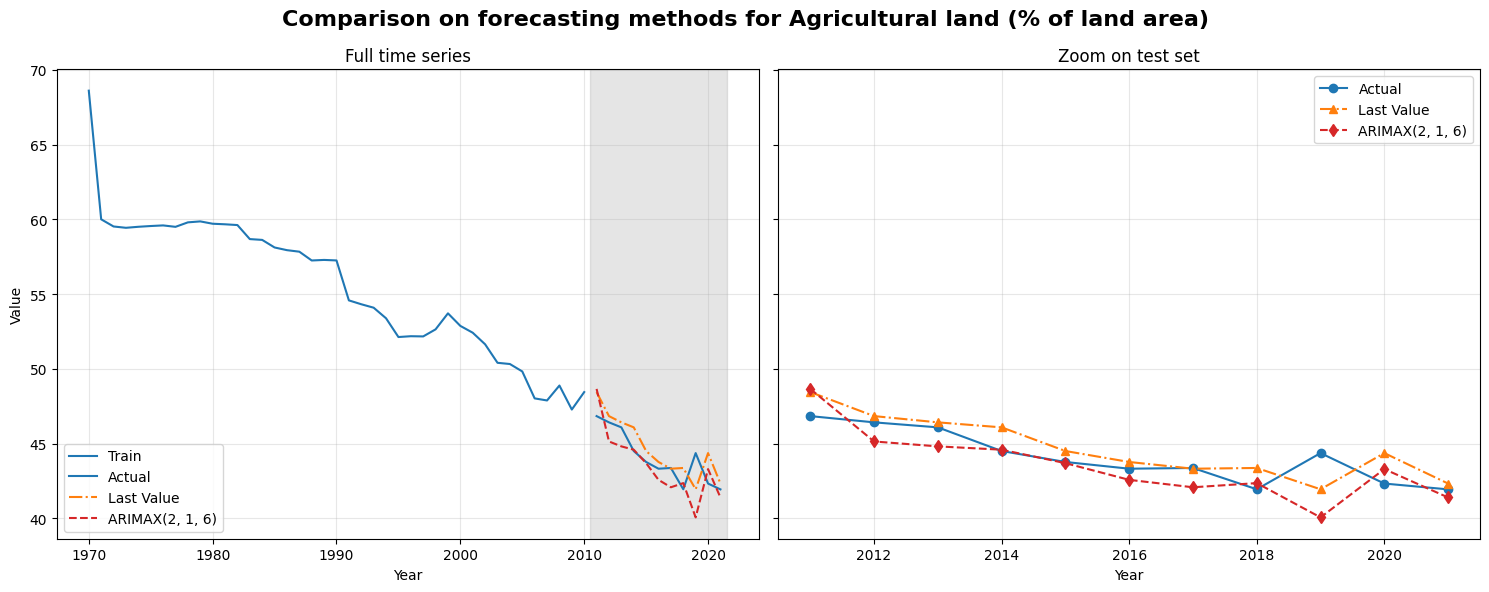

Metriche di errore per Agricultural land (% of land area):
  MAE -> Last Value: 1.04088, ARIMAX(2, 1, 6): 1.16329
  MSE -> Last Value: 1.66509, ARIMAX(2, 1, 6): 2.60919


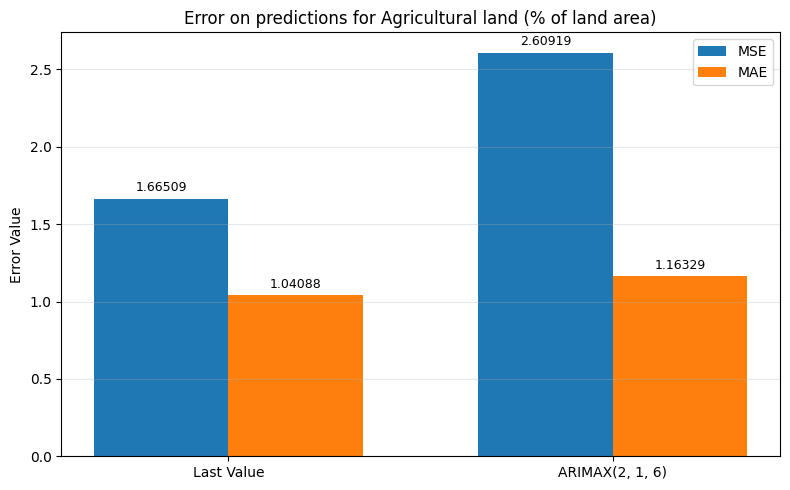

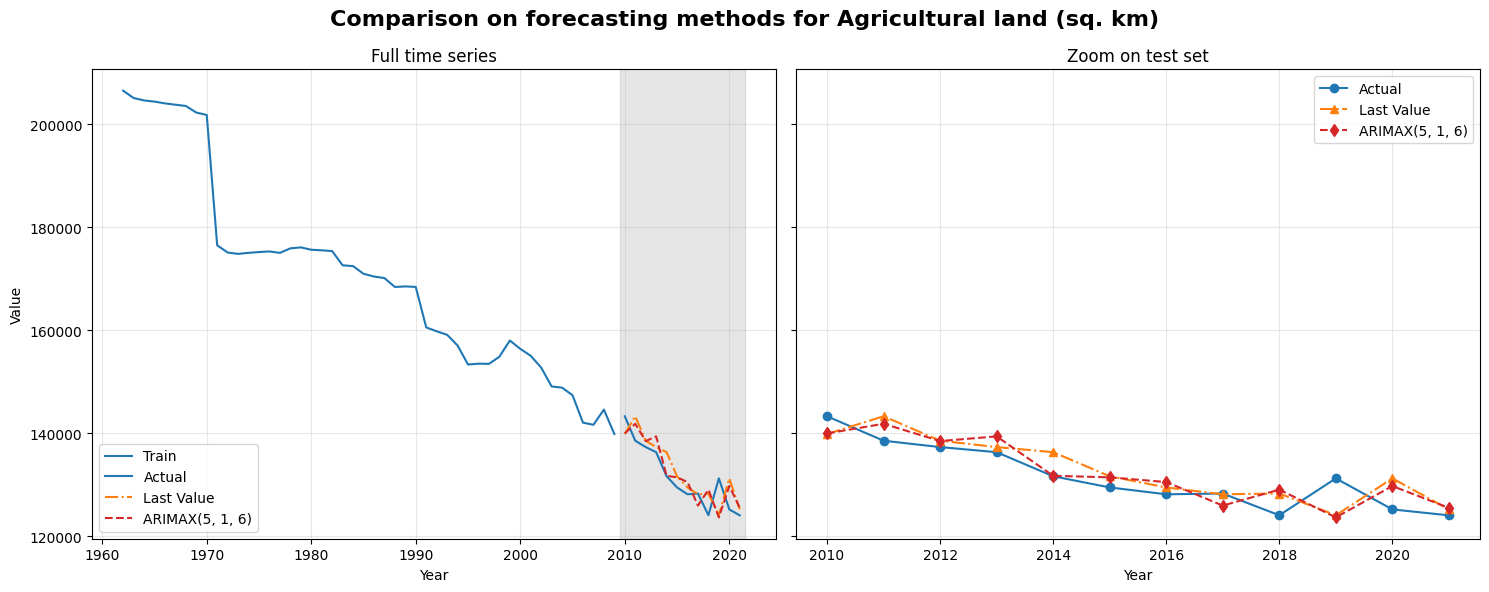

Metriche di errore per Agricultural land (sq. km):
  MAE -> Last Value: 3109.36092, ARIMAX(5, 1, 6): 3014.03242
  MSE -> Last Value: 14341262.68081, ARIMAX(5, 1, 6): 12710183.64711


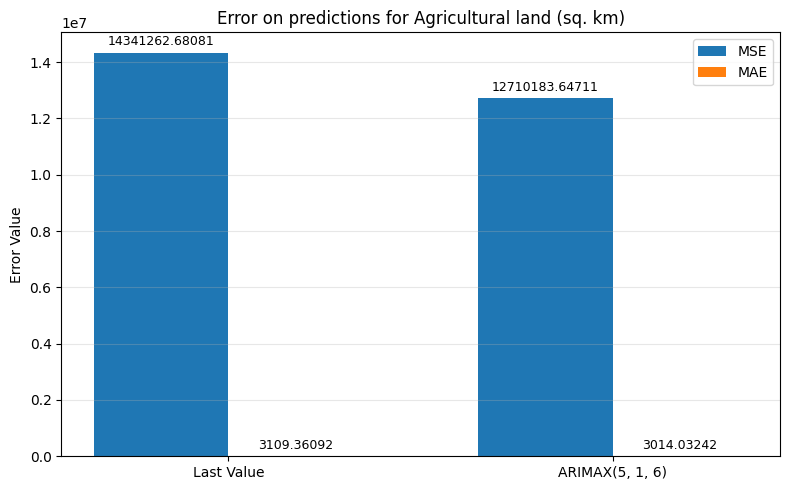

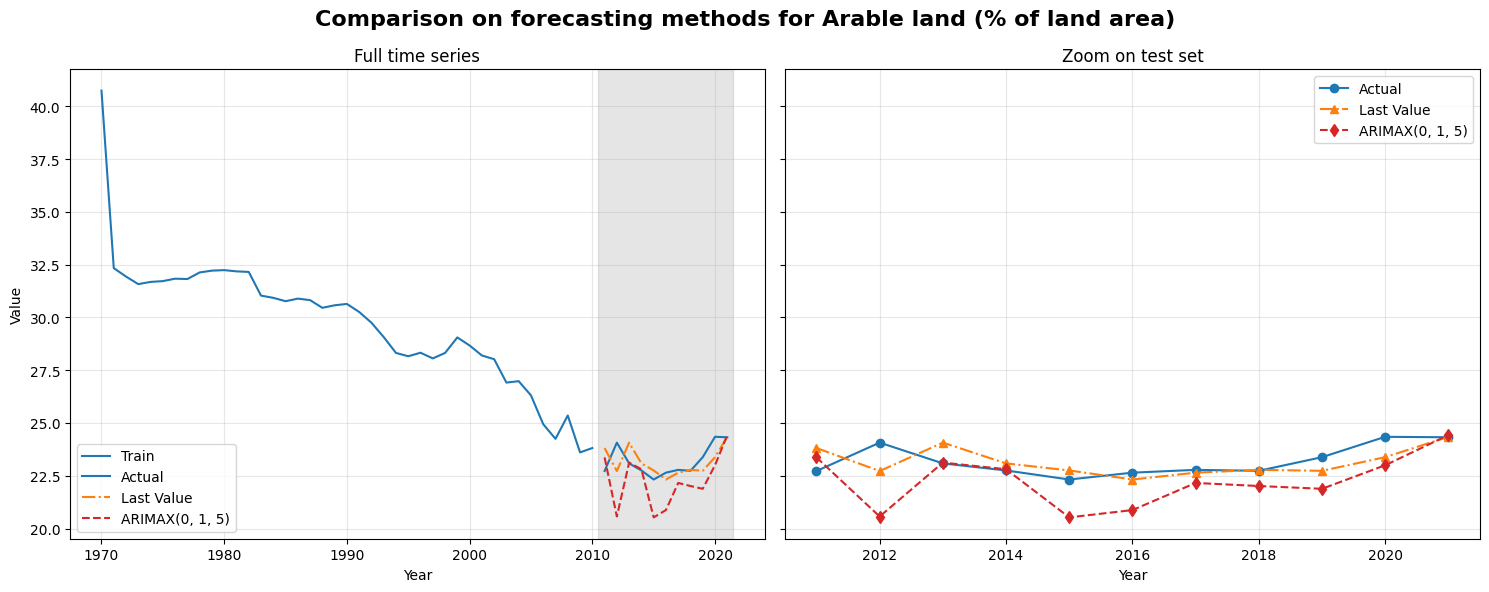

Metriche di errore per Arable land (% of land area):
  MAE -> Last Value: 0.57444, ARIMAX(0, 1, 5): 1.09969
  MSE -> Last Value: 0.52144, ARIMAX(0, 1, 5): 2.18292


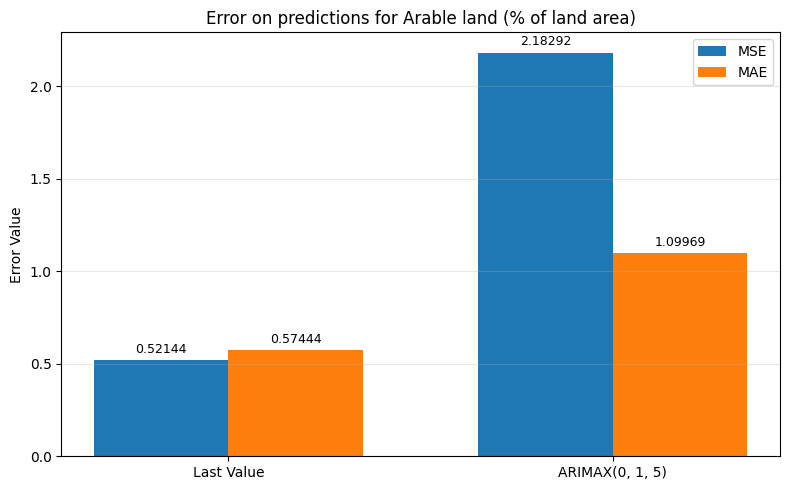

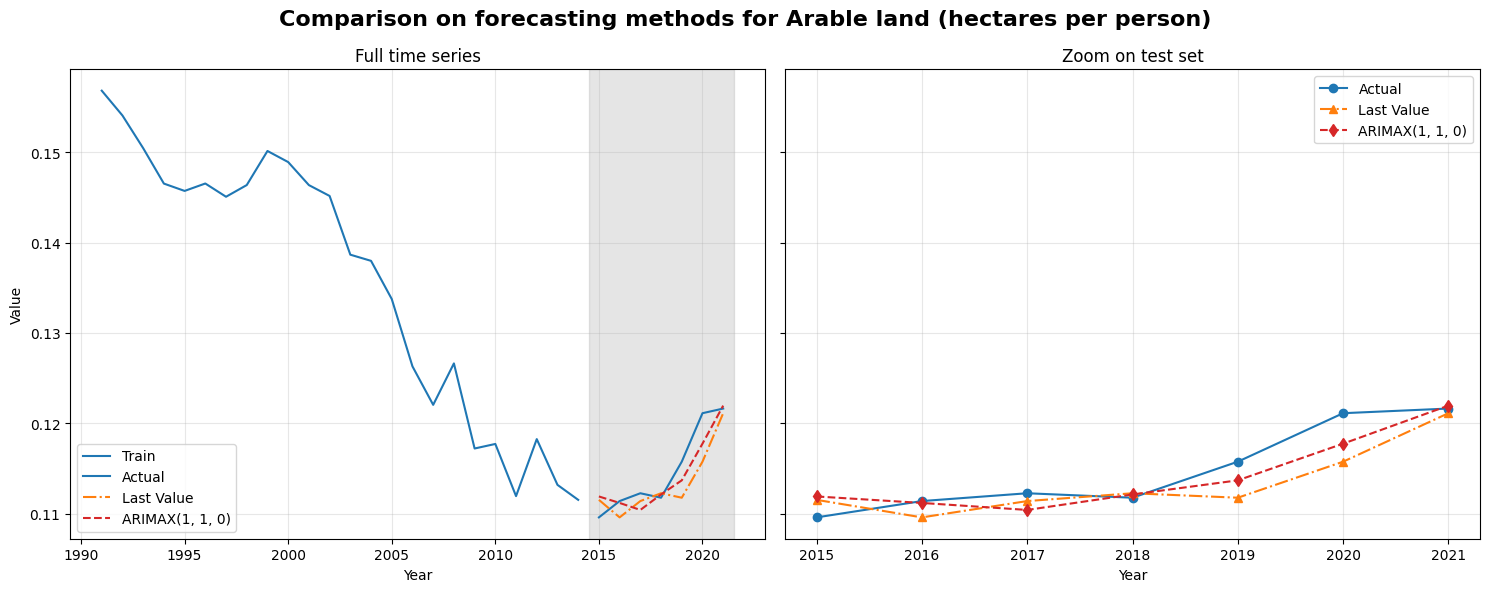

Metriche di errore per Arable land (hectares per person):
  MAE -> Last Value: 0.00214, ARIMAX(1, 1, 0): 0.00150
  MSE -> Last Value: 0.00001, ARIMAX(1, 1, 0): 0.00000


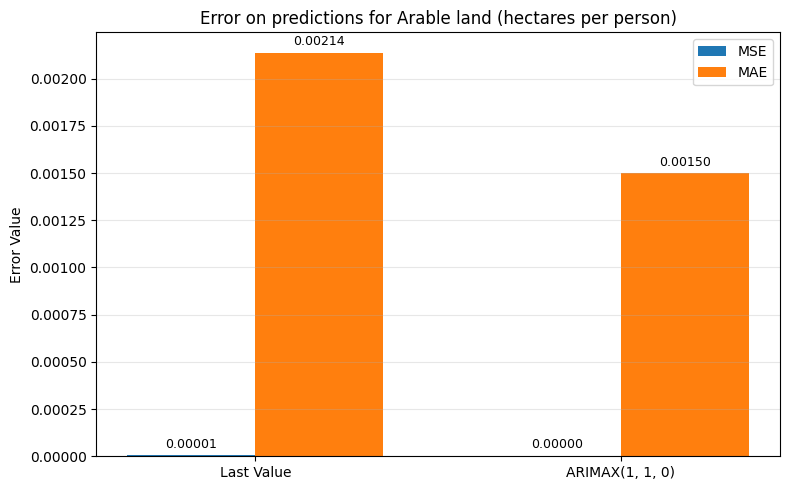

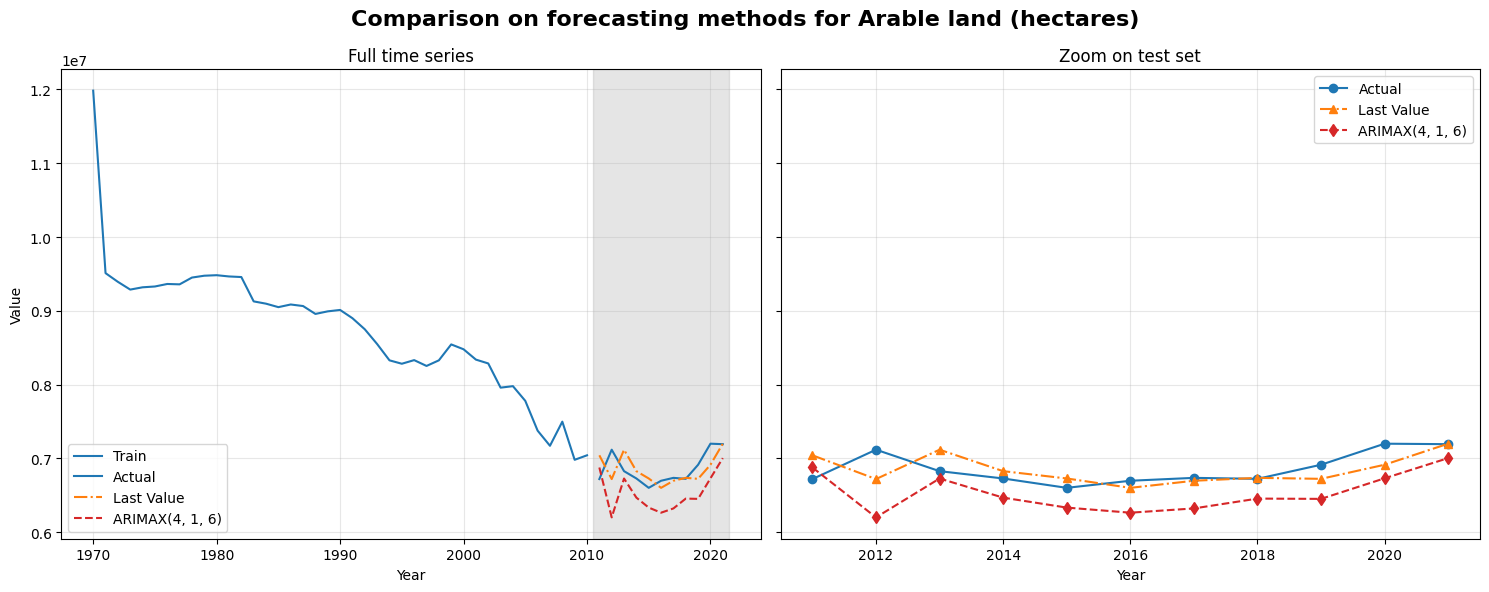

Metriche di errore per Arable land (hectares):
  MAE -> Last Value: 169868.72727, ARIMAX(4, 1, 6): 357893.94668
  MSE -> Last Value: 45598588641.27273, ARIMAX(4, 1, 6): 174182222255.86584


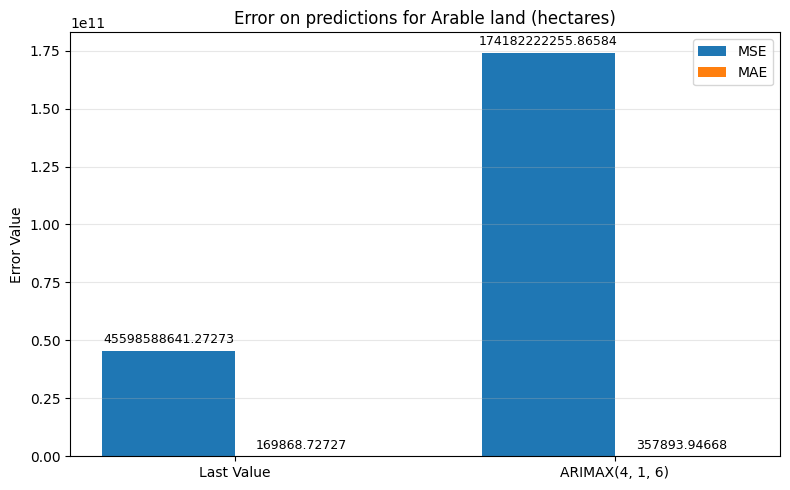

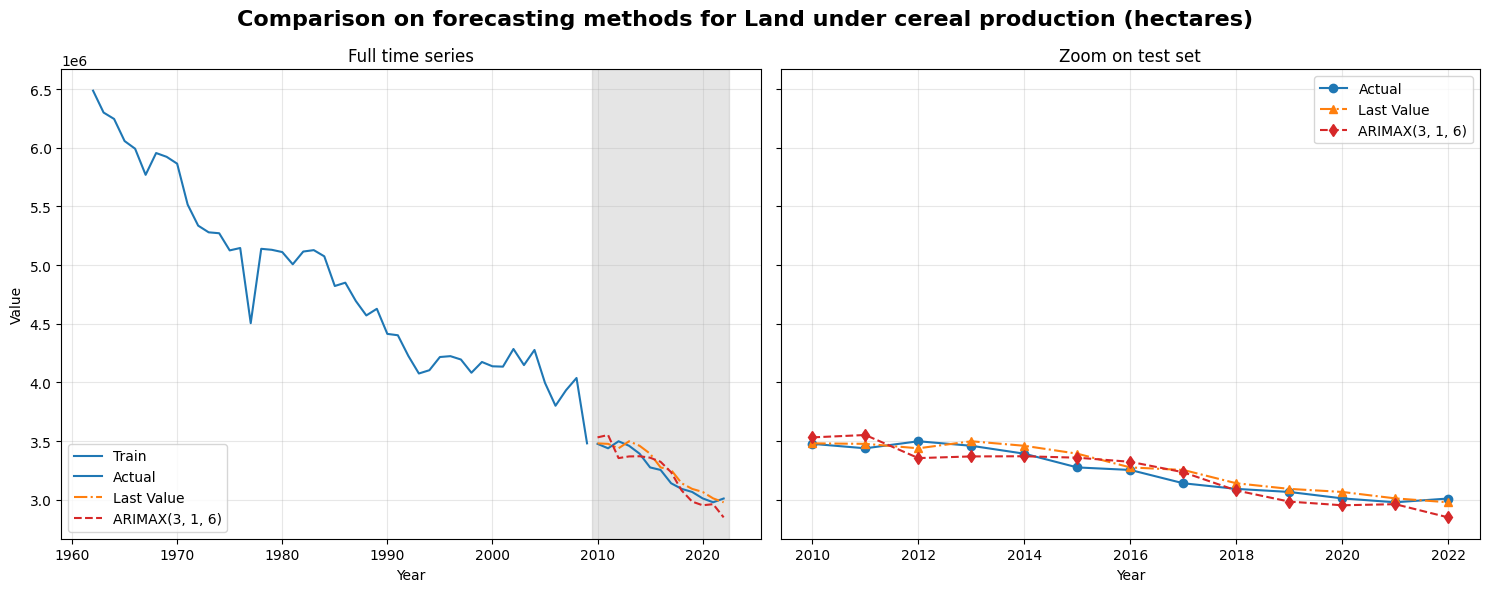

Metriche di errore per Land under cereal production (hectares):
  MAE -> Last Value: 50329.46154, ARIMAX(3, 1, 6): 77038.05670
  MSE -> Last Value: 3554542699.76923, ARIMAX(3, 1, 6): 7856752925.13515


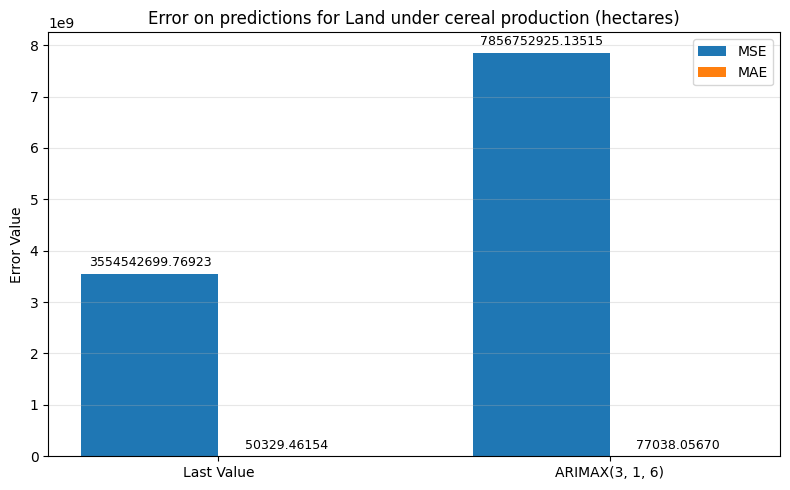

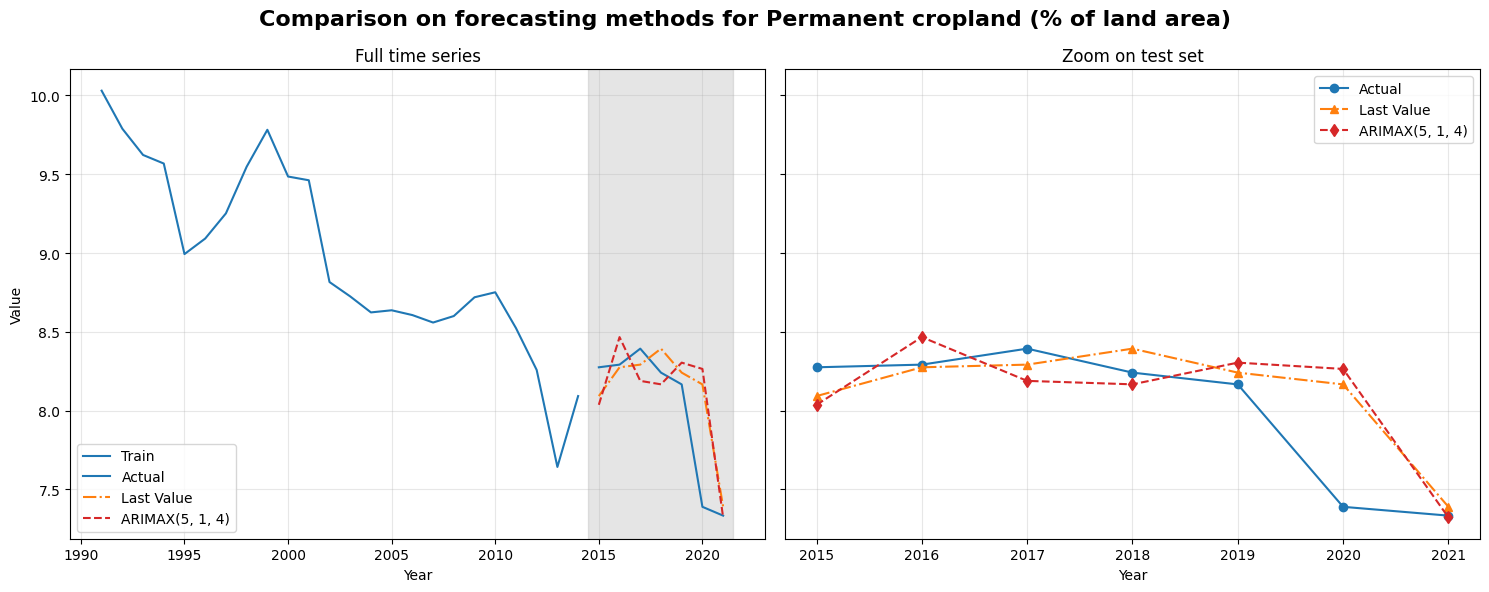

Metriche di errore per Permanent cropland (% of land area):
  MAE -> Last Value: 0.19438, ARIMAX(5, 1, 4): 0.24513
  MSE -> Last Value: 0.09704, ARIMAX(5, 1, 4): 0.13135


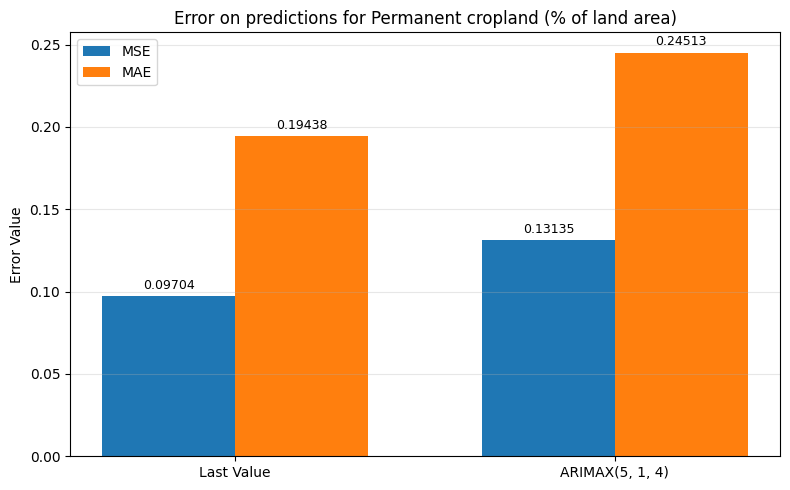

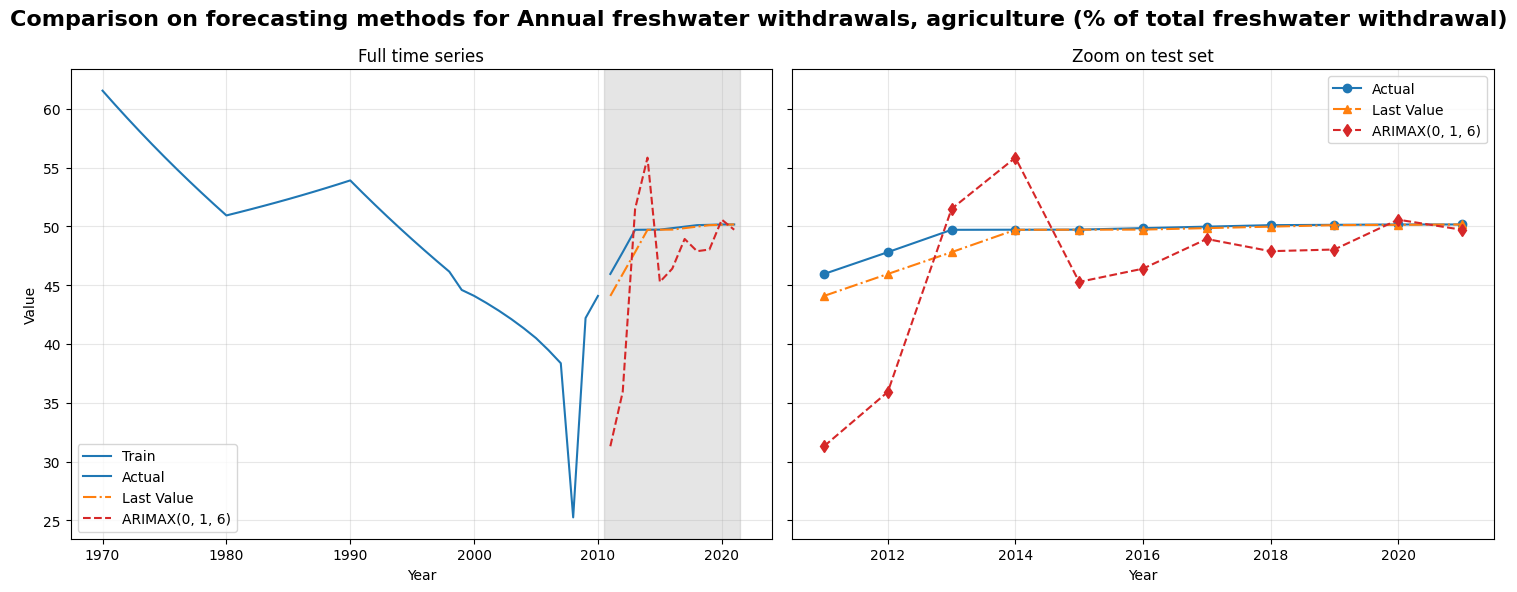

Metriche di errore per Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal):
  MAE -> Last Value: 0.55247, ARIMAX(0, 1, 6): 4.41368
  MSE -> Last Value: 0.96255, ARIMAX(0, 1, 6): 39.89720


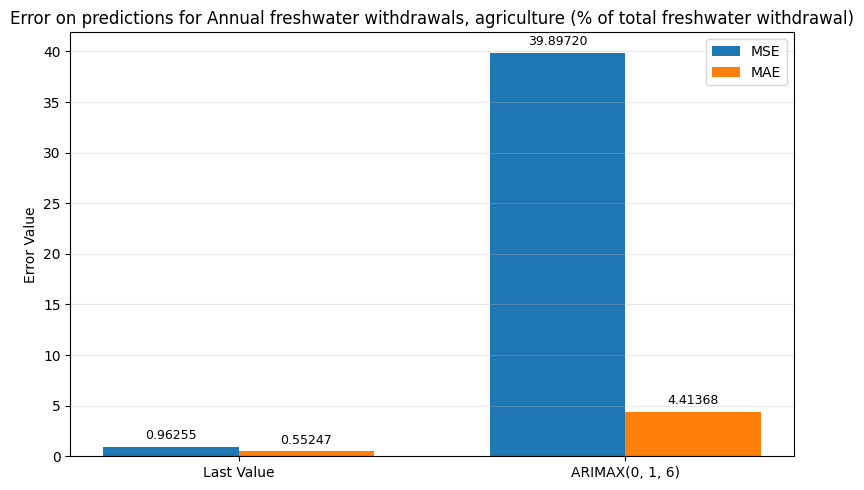

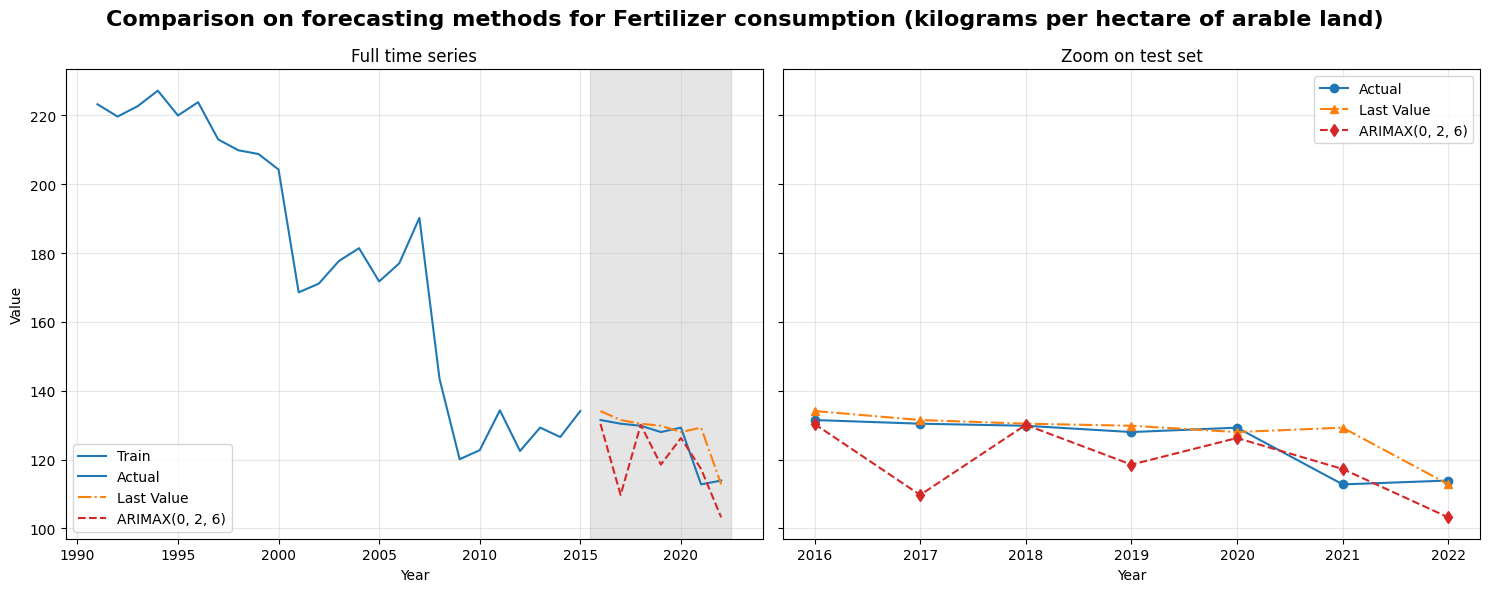

Metriche di errore per Fertilizer consumption (kilograms per hectare of arable land):
  MAE -> Last Value: 3.57209, ARIMAX(0, 2, 6): 7.10705
  MSE -> Last Value: 40.90536, ARIMAX(0, 2, 6): 94.73890


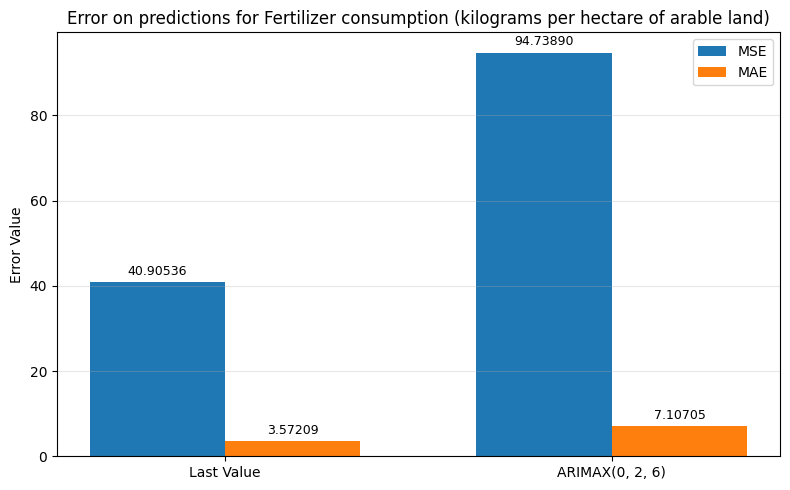

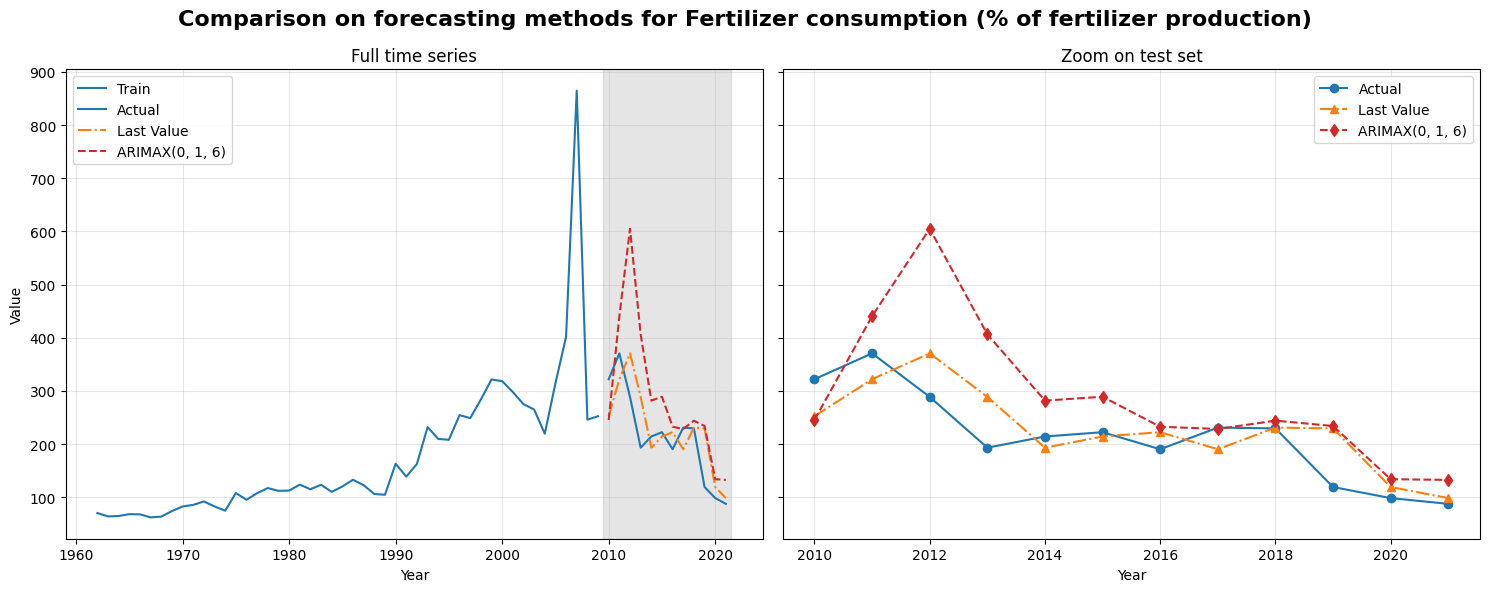

Metriche di errore per Fertilizer consumption (% of fertilizer production):
  MAE -> Last Value: 45.09998, ARIMAX(0, 1, 6): 88.77499
  MSE -> Last Value: 3247.80755, ARIMAX(0, 1, 6): 15318.37968


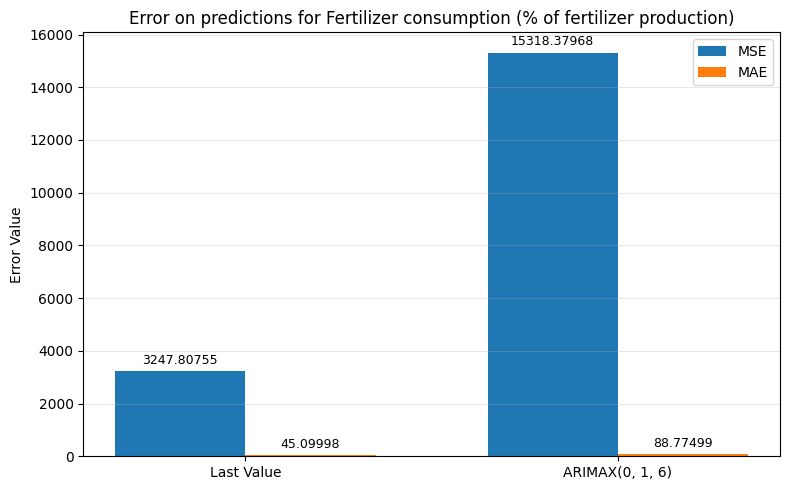

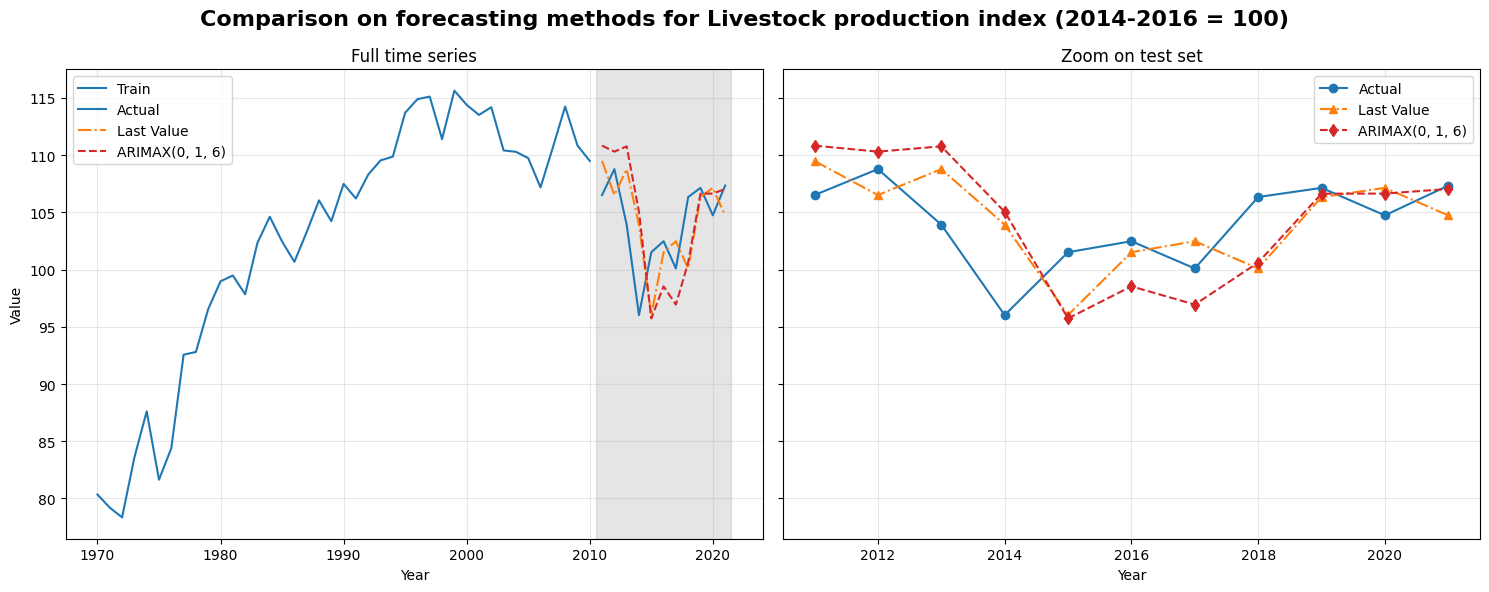

Metriche di errore per Livestock production index (2014-2016 = 100):
  MAE -> Last Value: 3.53364, ARIMAX(0, 1, 6): 3.90959
  MSE -> Last Value: 17.16268, ARIMAX(0, 1, 6): 22.24805


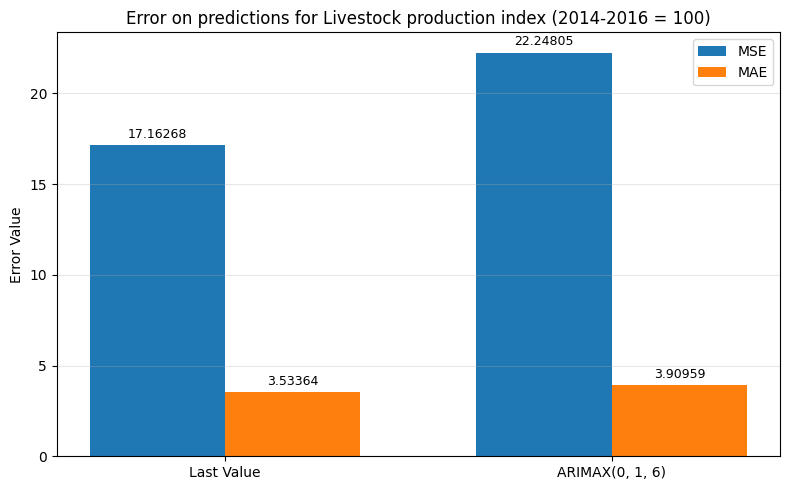

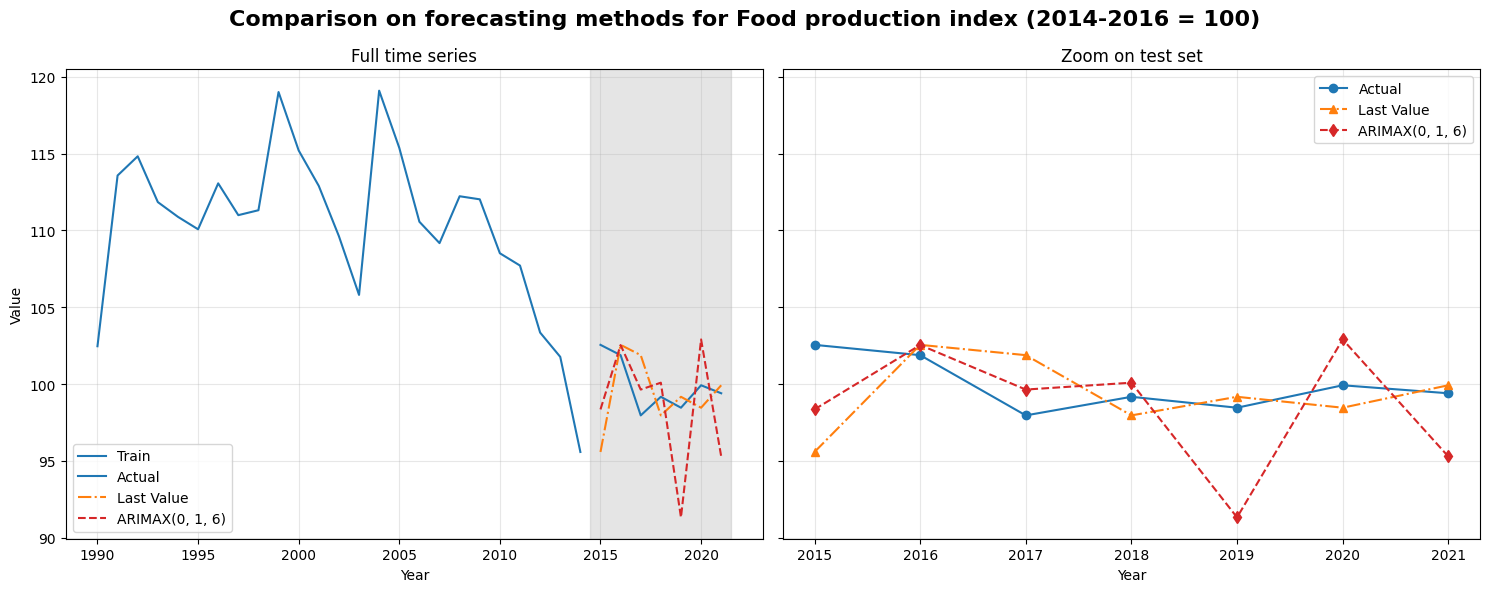

Metriche di errore per Food production index (2014-2016 = 100):
  MAE -> Last Value: 2.20857, ARIMAX(0, 1, 6): 3.09840
  MSE -> Last Value: 9.82377, ARIMAX(0, 1, 6): 14.06892


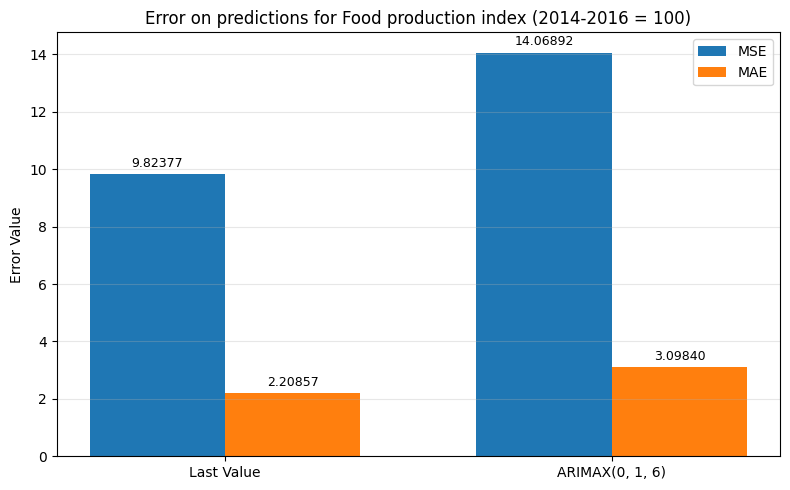

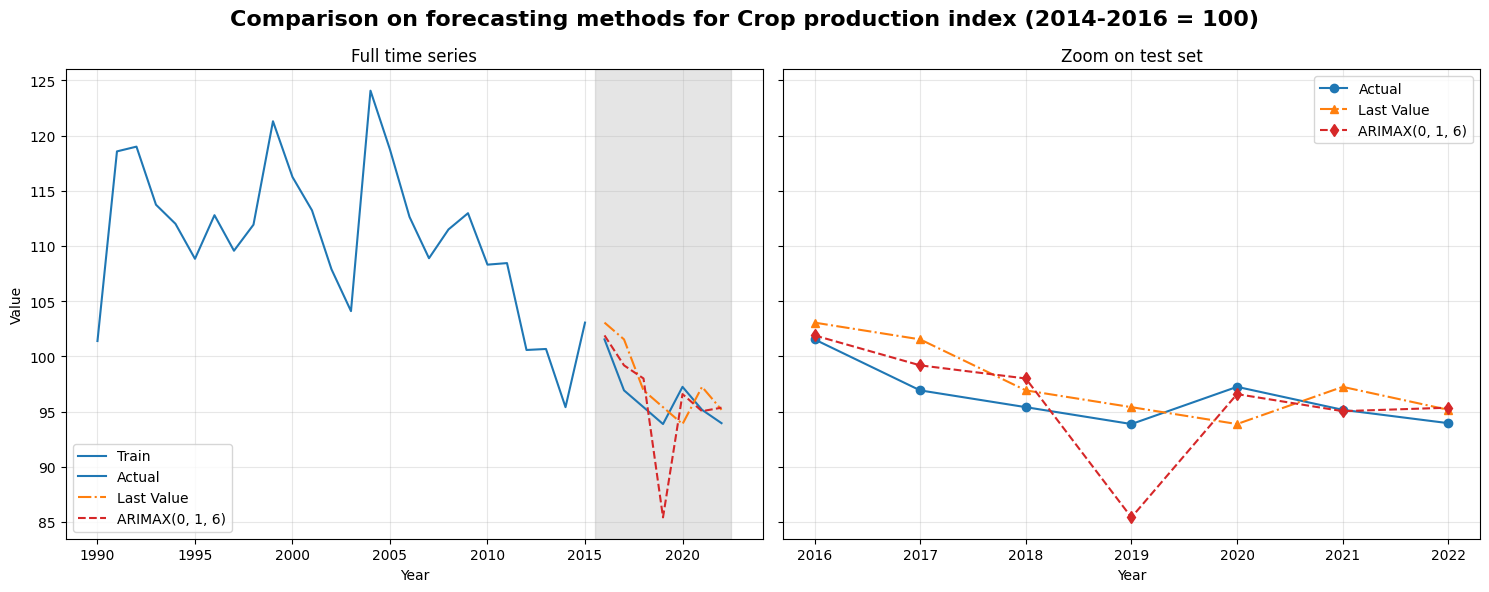

Metriche di errore per Crop production index (2014-2016 = 100):
  MAE -> Last Value: 2.26429, ARIMAX(0, 1, 6): 2.26587
  MSE -> Last Value: 6.49336, ARIMAX(0, 1, 6): 12.27426


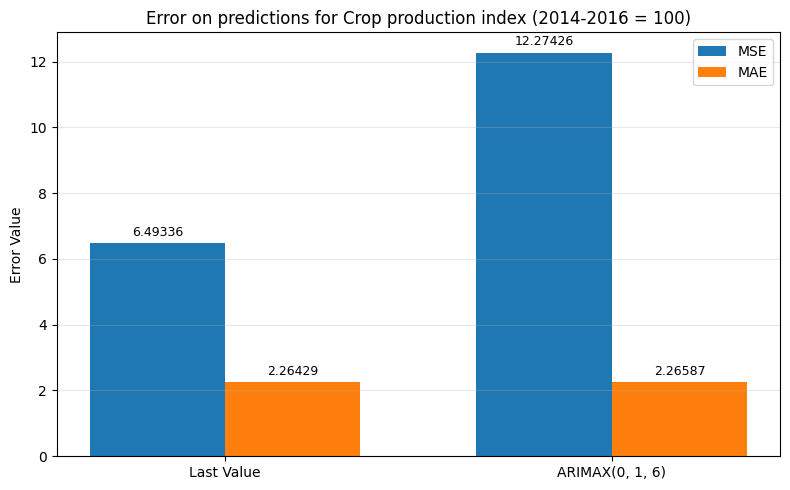

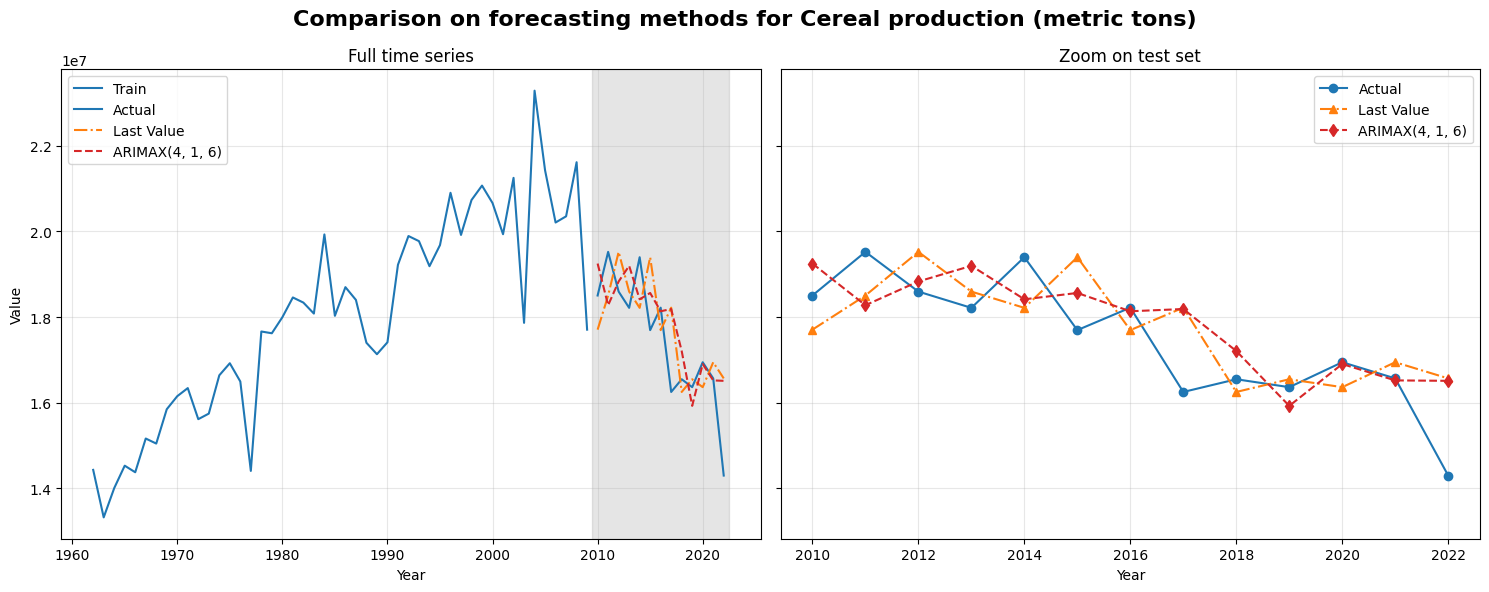

Metriche di errore per Cereal production (metric tons):
  MAE -> Last Value: 938943.03077, ARIMAX(4, 1, 6): 805530.52881
  MSE -> Last Value: 1297001863436.11963, ARIMAX(4, 1, 6): 1085452867738.78430


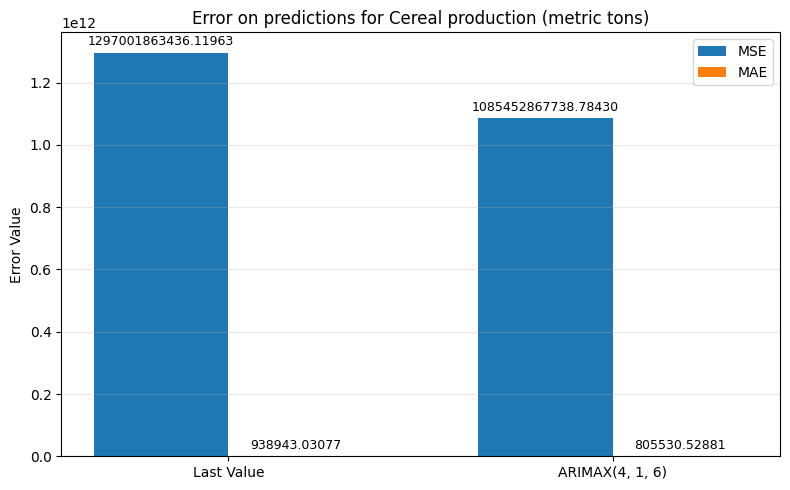

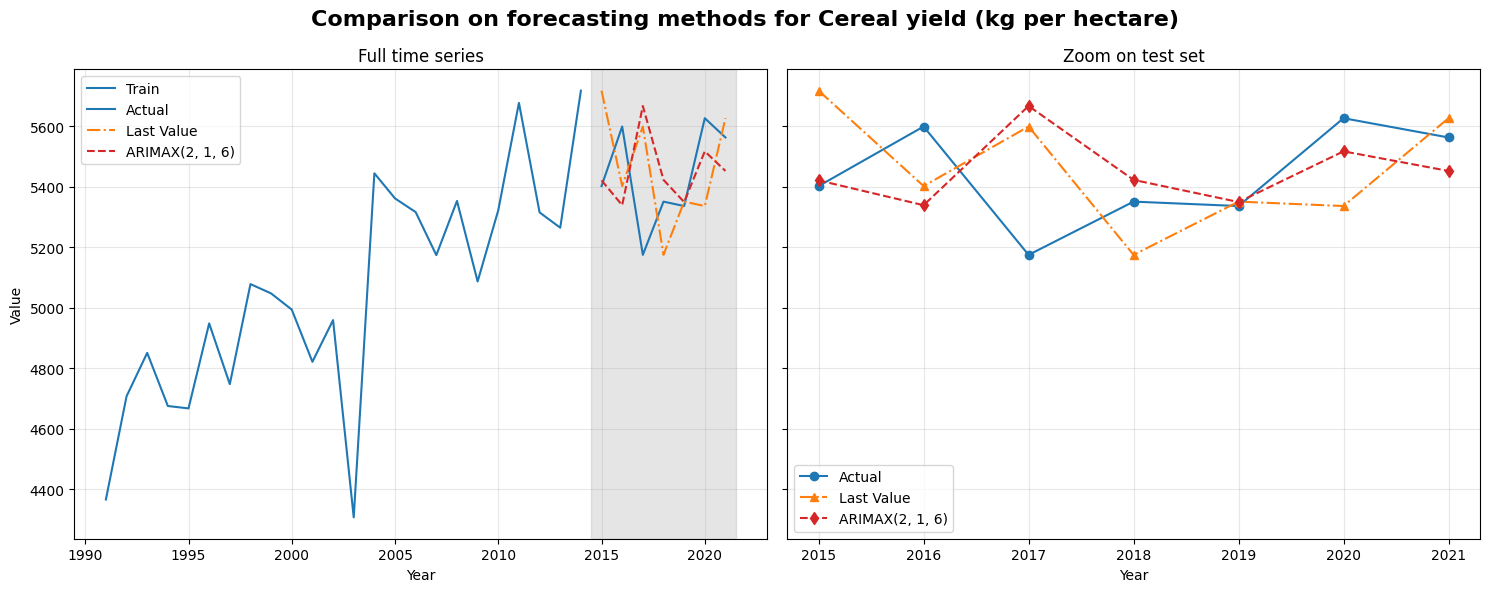

Metriche di errore per Cereal yield (kg per hectare):
  MAE -> Last Value: 211.55714, ARIMAX(2, 1, 6): 153.72298
  MSE -> Last Value: 62515.84429, ARIMAX(2, 1, 6): 48514.91892


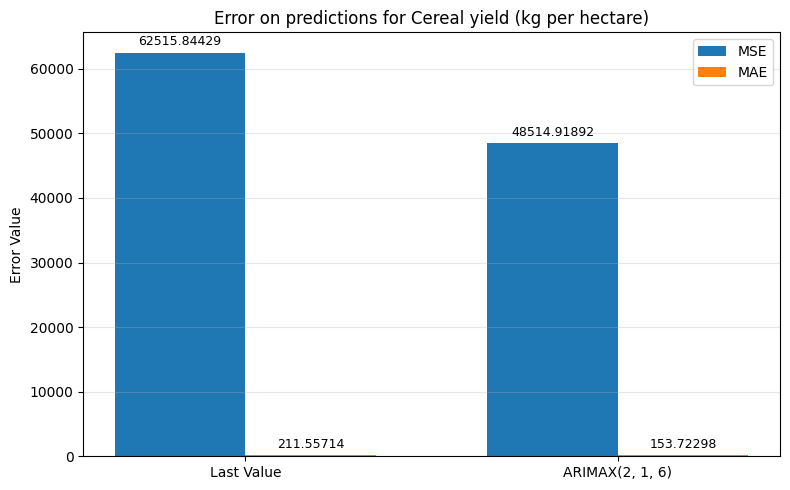

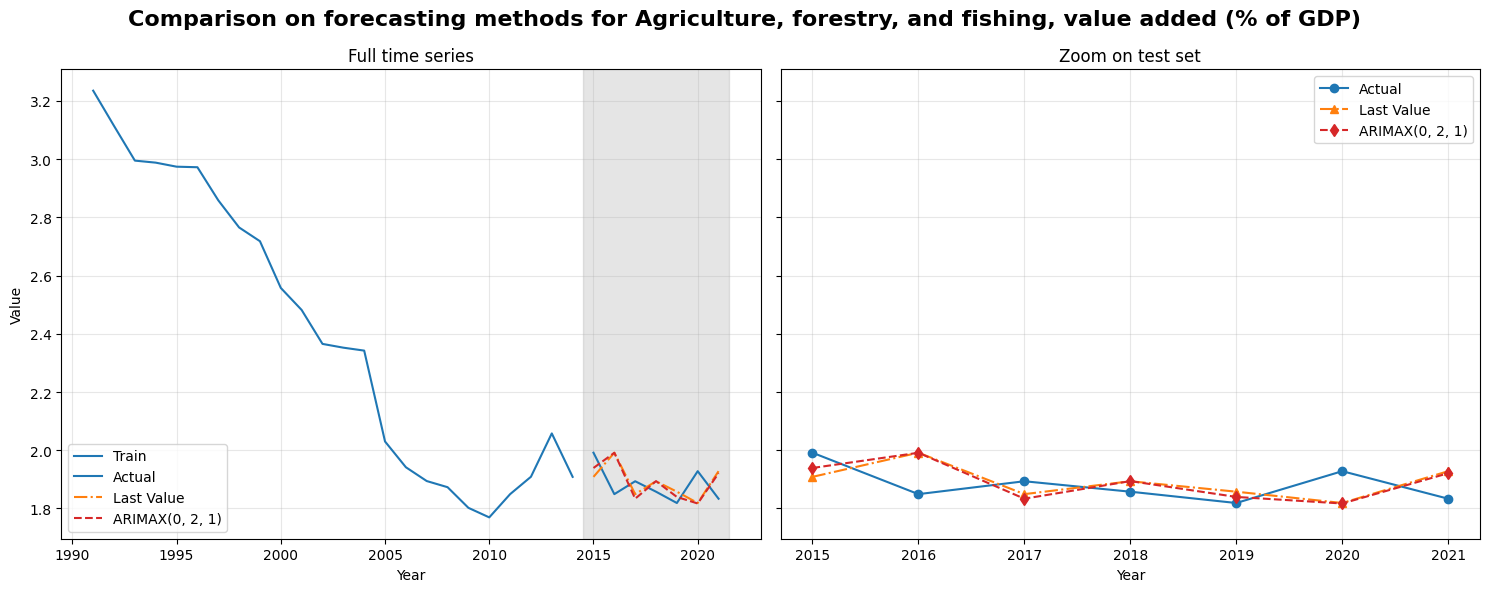

Metriche di errore per Agriculture, forestry, and fishing, value added (% of GDP):
  MAE -> Last Value: 0.07835, ARIMAX(0, 2, 1): 0.07291
  MSE -> Last Value: 0.00755, ARIMAX(0, 2, 1): 0.00690


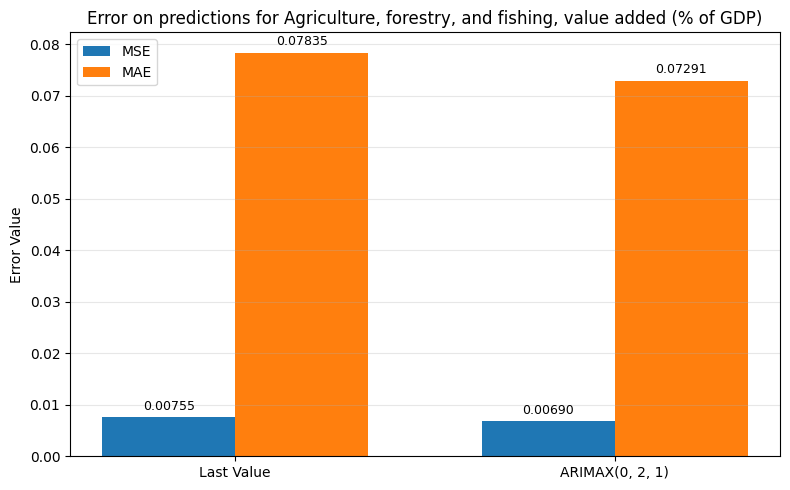

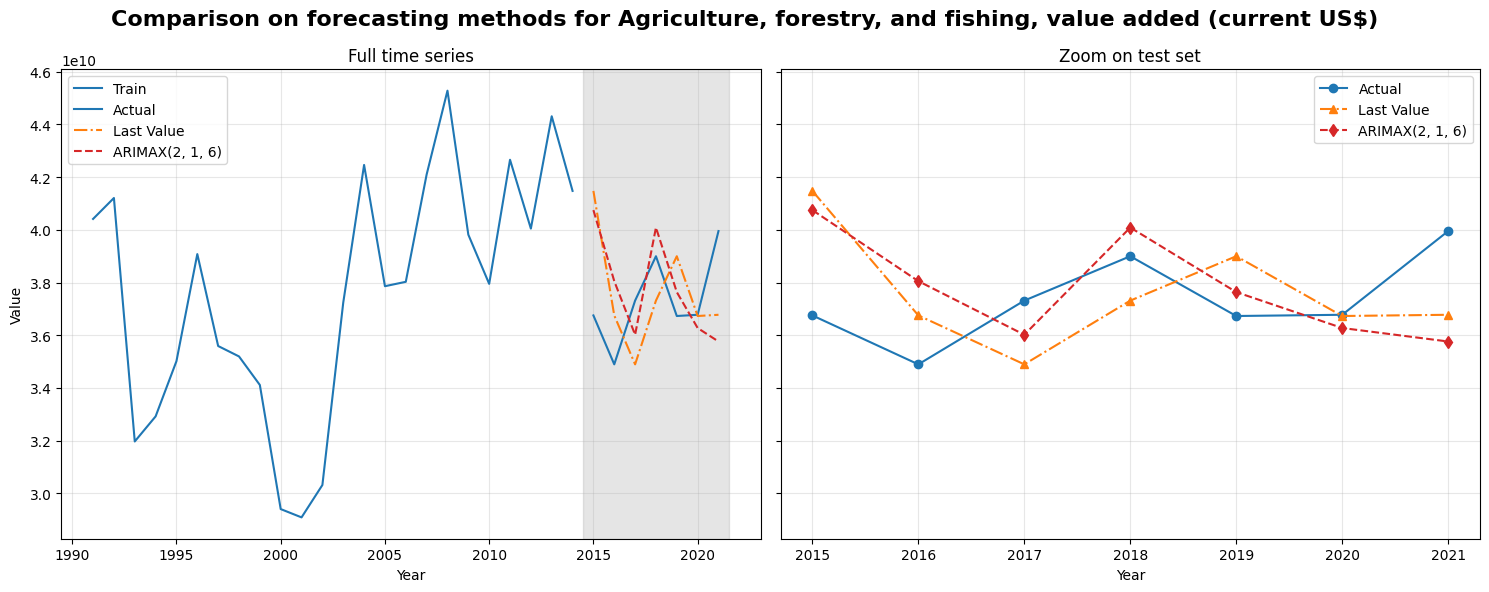

Metriche di errore per Agriculture, forestry, and fishing, value added (current US$):
  MAE -> Last Value: 2310709496.79121, ARIMAX(2, 1, 6): 2162691240.41180
  MSE -> Last Value: 7098401571870432256.00000, ARIMAX(2, 1, 6): 6778711444744011776.00000


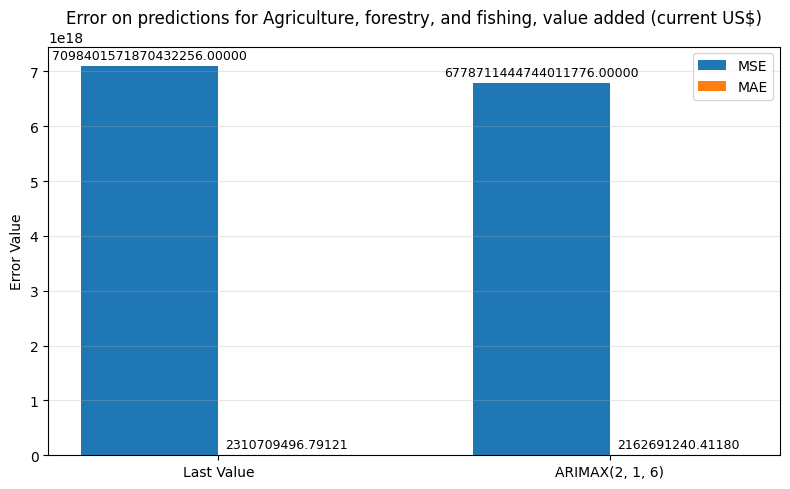

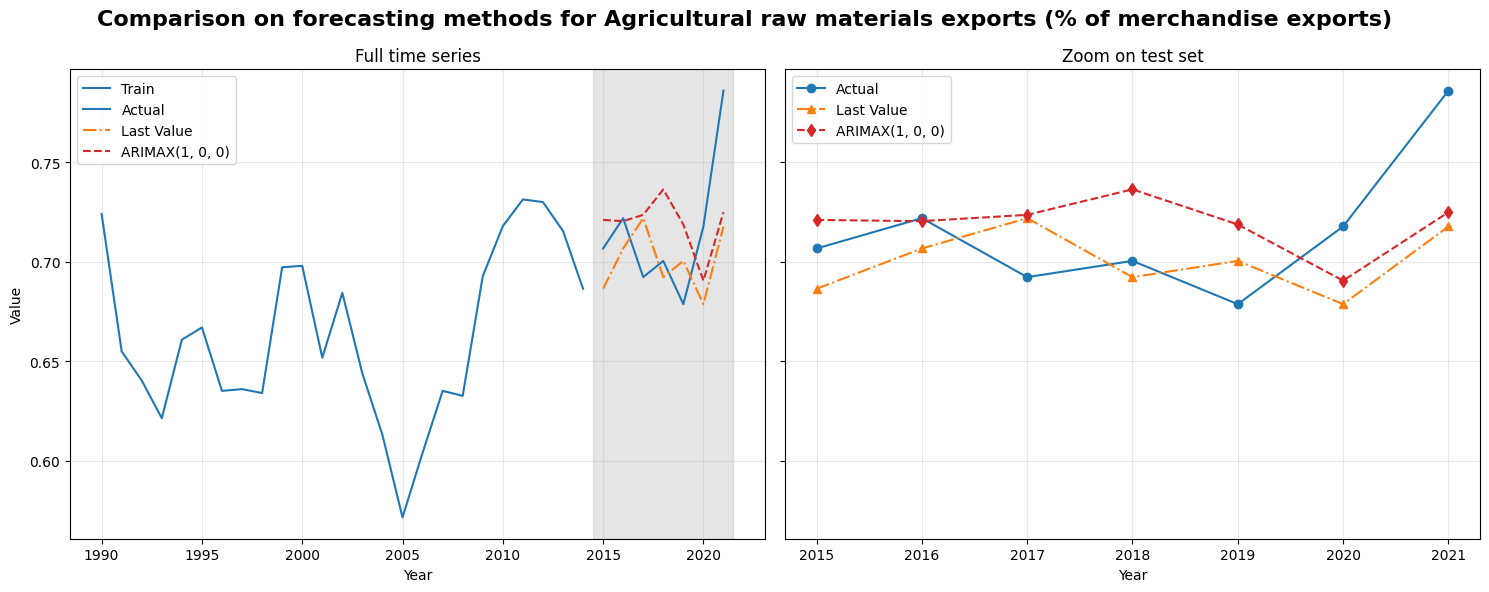

Metriche di errore per Agricultural raw materials exports (% of merchandise exports):
  MAE -> Last Value: 0.02892, ARIMAX(1, 0, 0): 0.03023
  MSE -> Last Value: 0.00118, ARIMAX(1, 0, 0): 0.00122


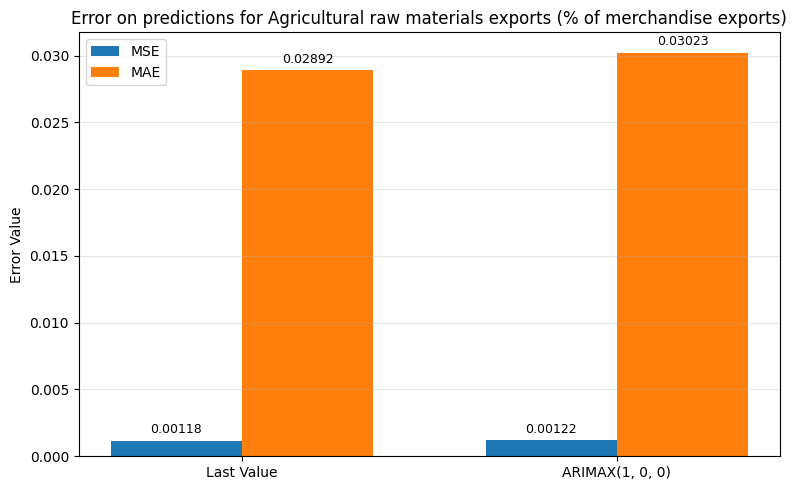

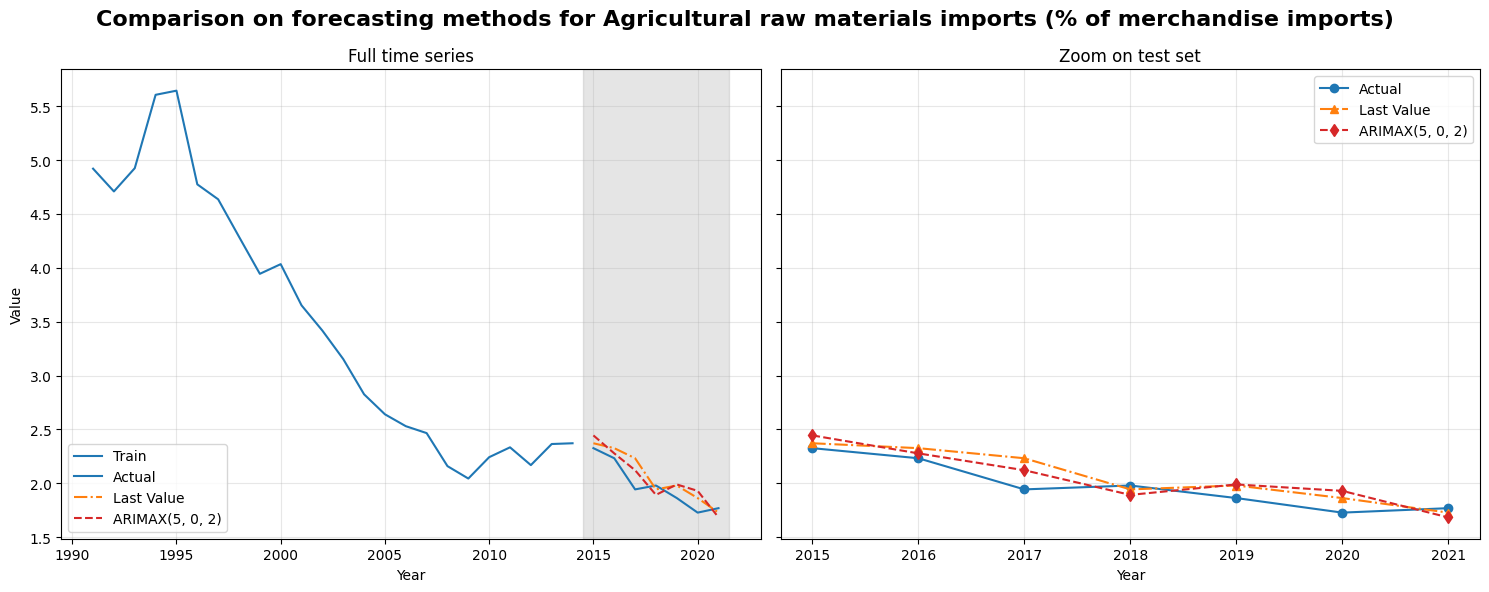

Metriche di errore per Agricultural raw materials imports (% of merchandise imports):
  MAE -> Last Value: 0.10821, ARIMAX(5, 0, 2): 0.12039
  MSE -> Last Value: 0.01848, ARIMAX(5, 0, 2): 0.01707


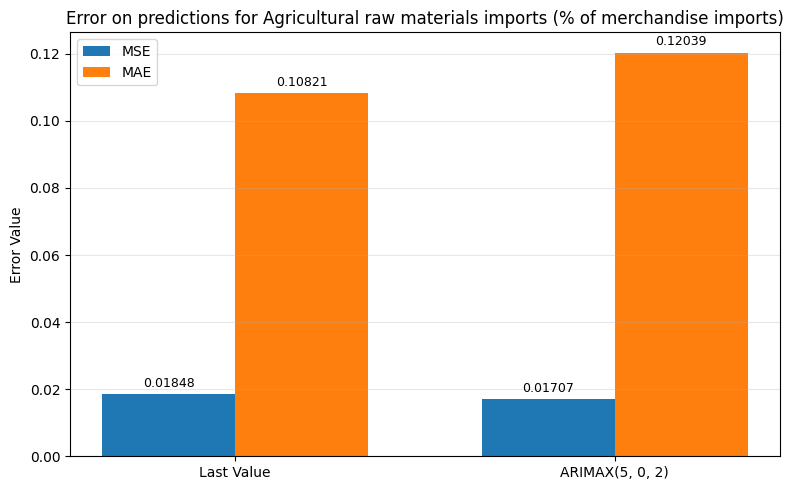

In [39]:
if 'all_results' not in globals() or not all_results:
    print("Dizionario 'all_results' non trovato o vuoto.")
else:
    for target, results_df in all_results.items():
        try:
            # prendo la riga in df_orders
            row = df_orders[df_orders["Target"] == target]
            if row.empty:
                print(f"Dettagli non trovati in df_orders per {target}. Skipping.")
                continue
            
            # p, d, q
            best_order_val = row['Best order'].iloc[0]
            if isinstance(best_order_val, str):
                order = ast.literal_eval(best_order_val)
            else:
                order = tuple(best_order_val)
            p, d, q = map(int, order)
            
            # esogene usate
            exog_val = row['Exog_Used'].iloc[0]
            if not isinstance(exog_val, list):
                exog_val = [exog_val] if exog_val and pd.notna(exog_val) else []

            # rigenero dataset completo per ottenere train/test
            wide_df = prepare_wide_dataset(df, target)
            keep_cols = ['Year', target] + [c for c in exog_val if c in wide_df.columns]
            keep_cols = list(dict.fromkeys(keep_cols))
            data_subset = wide_df[keep_cols].dropna().reset_index(drop=True)
            
            # rifaccio split
            TRAIN_LEN = int(0.8 * len(data_subset))
            train_data = data_subset.iloc[:TRAIN_LEN]
            
            # 'results_df' è il nostro set di test. Rinominiamo 'actual' in 'Value'
            # per compatibilità con il tuo codice di plot.
            test_data = results_df.rename(columns={'actual': 'Value'})
            
            if test_data.empty or train_data.empty:
                print(f"Dati di train o test vuoti per {target}. Skipping plot.")
                continue
        except Exception as e:
            print(f"Errore nella preparazione dati per il plot di {target}: {e}")
            continue

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 6))
        fig.suptitle(f"Comparison on forecasting methods for {target}", fontsize=16, fontweight="bold")
        
        ax1.plot(train_data['Year'], train_data[target], label='Train')
        ax1.plot(test_data['Year'], test_data['Value'], color=colors[0], linestyle='-', label='Actual')
        ax1.plot(test_data['Year'], test_data['pred_last_value'], color=colors[2], linestyle='-.', label='Last Value')
        ax1.plot(test_data['Year'], test_data['pred_ARIMAX'], color=colors[3], linestyle='--', label=f'ARIMAX{order}')
        ax1.legend(loc='best')
        ax1.set_title("Full time series")
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.grid(True, alpha=0.3)
        start_year = int(test_data['Year'].iloc[0])
        end_year = int(test_data['Year'].iloc[-1])
        ax1.axvspan(start_year - 0.5, end_year + 0.5, color='#808080', alpha=0.2, label='Test Set')

        ax2.plot(test_data['Year'], test_data['Value'], color=colors[0], linestyle='-', label='Actual', marker="o")
        ax2.plot(test_data['Year'], test_data['pred_last_value'], color=colors[2], linestyle='-.', label='Last Value', marker="^")
        ax2.plot(test_data['Year'], test_data['pred_ARIMAX'], color=colors[3], linestyle='--', label=f'ARIMAX{order}', marker="d")
        ax2.legend(loc='best')
        ax2.set_title("Zoom on test set")
        ax2.set_xlabel('Year')
        ax2.grid(True, alpha=0.3)
        
        ax1.tick_params(labelbottom=True)
        ax2.tick_params(labelbottom=True)
        plt.setp(ax2.get_xticklabels(), visible=True)
        plt.tight_layout() 
        plt.show()

        mae_last = mean_absolute_error(test_data['Value'], test_data['pred_last_value'])
        mae_arimax = mean_absolute_error(test_data['Value'], test_data['pred_ARIMAX'])

        mse_last = mean_squared_error(test_data['Value'], test_data['pred_last_value'])
        mse_arimax = mean_squared_error(test_data['Value'], test_data['pred_ARIMAX'])

        print(f"Metriche di errore per {target}:")
        print(f"  MAE -> Last Value: {mae_last:.5f}, ARIMAX{order}: {mae_arimax:.5f}")
        print(f"  MSE -> Last Value: {mse_last:.5f}, ARIMAX{order}: {mse_arimax:.5f}")
        
        results_metrics = pd.DataFrame({
            'Method': ['Last Value', f'ARIMAX{order}'],
            'MSE': [mse_last, mse_arimax],
            'MAE': [mae_last, mae_arimax]
        })

        fig, ax = plt.subplots(figsize=(8, 5))
        x = np.arange(len(results_metrics['Method']))
        width = 0.35

        bar1 = ax.bar(x - width/2, results_metrics['MSE'], width, label='MSE')
        bar2 = ax.bar(x + width/2, results_metrics['MAE'], width, label='MAE')

        ax.set_xticks(x)
        ax.set_xticklabels(results_metrics['Method'])
        ax.set_title(f"Error on predictions for {target}")
        ax.set_ylabel("Error Value")
        ax.legend()
        ax.grid(alpha=0.3, axis='y')

        def add_labels(bars):
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.5f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9)
        
        add_labels(bar1)
        add_labels(bar2)

        plt.tight_layout()
        plt.show()

In [ ]:
import statsmodels.api as sm
import ast

# Scegli i target da analizzare
# Scegline uno dove l'RMSE era basso (buon fit) e uno dove era alto (cattivo fit)
targets_da_diagnosticare = [
    "Rural population (% of total population)", # Esempio BUONO
    "Rural population growth (annual %)"      # Esempio CATTIVO (o viceversa, dipende dai tuoi RMSE)
]

for target in targets_da_diagnosticare:
    if target not in all_results:
        print(f"Target {target} non trovato in all_results. Skipping.")
        continue
        
    print(f"\n{'='*40}\n DIAGNOSTICA PER: {target.upper()}\n{'='*40}")
    
    try:
        # --- 1. Recupera i dati e i parametri (come prima) ---
        row = df_orders[df_orders["Target"] == target]
        best_order_val = row['Best order'].iloc[0]
        exog_val = row['Exog_Used'].iloc[0]

        if not isinstance(exog_val, list):
            exog_val = [exog_val] if exog_val and pd.notna(exog_val) else []

        if isinstance(best_order_val, str):
            order = ast.literal_eval(best_order_val)
        else:
            order = tuple(best_order_val)
        
        # --- 2. Prepara il dataset completo (tutti i dati, non solo train) ---
        wide_df = prepare_wide_dataset(df, target)
        keep_cols = [target] + [c for c in exog_val if c in wide_df.columns]
        data_subset = wide_df[keep_cols].dropna().reset_index(drop=True)
        
        endog = data_subset[target]
        exog = data_subset[exog_val] if exog_val else None

        if endog.empty:
            print(f"Nessun dato per {target} dopo il setup. Skipping.")
            continue
            
        # --- 3. Fitta UN MODELLO sul dataset COMPLETO ---
        # Usiamo i parametri (p,d,q) che abbiamo trovato essere "ottimali"
        model = sm.tsa.SARIMAX(
            endog,
            exog=exog,
            order=order,
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        results = model.fit(disp=False, maxiter=200)
        
        # --- 4. GENERA IL PLOT DELLE DIAGNOSTICHE ---
        print(f"Visualizzazione diagnostiche per {target} con ordine {order}")
        
        # Crea la figura per le diagnostiche
        fig = results.plot_diagnostics(figsize=(15, 12))
        fig.suptitle(f"Diagnostiche Modello per: {target}", y=1.02, fontsize=16)
        plt.tight_layout()
        plt.show()

        # Stampa un riassunto del modello
        print(results.summary())

    except Exception as e:
        print(f"Errore durante la diagnostica per {target}: {e}")